# Maratona de Filmes (SuperComp)

## Relatório Final

#### Insper 2023.1
Aluno: Guilherme Rosada


---

# Introdução

Nos últimos anos, o crescimento exponencial dos dados e a demanda por processamento de informações complexas têm impulsionado o desenvolvimento de técnicas de computação mais avançadas. Nesse contexto, a Computação Paralela e a Computação com GPU (Graphics Processing Unit) têm se destacado como abordagens poderosas para melhorar a eficiência e o desempenho de tarefas computacionais intensivas.

A Computação Paralela refere-se à execução simultânea de múltiplas tarefas computacionais, dividindo um problema em subproblemas menores que podem ser processados em paralelo. Essa abordagem permite que os recursos de processamento disponíveis sejam utilizados de forma mais eficiente, acelerando a solução de problemas complexos. A utilização de múltiplos processadores ou núcleos de processamento em conjunto permite um processamento mais rápido e uma capacidade de processamento maior.

Por outro lado, a Computação com GPU envolve o uso de unidades de processamento gráfico (GPUs) para realizar tarefas computacionais. Originalmente desenvolvidas para renderização de gráficos em jogos e aplicações de multimídia, as GPUs têm se mostrado altamente eficientes em realizar operações matemáticas e processamento paralelo. Com sua arquitetura massivamente paralela, as GPUs podem lidar com grande volume de dados simultaneamente, resultando em uma significativa aceleração de processos computacionais.

Este relatório visa explorar algumas técnicas de computação paralela, variando as abordgens utilizadas (heurísticas), os inputs, as restrições etc.

## Contextualização

Você quer passar um final de semana assistindo ao máximo de filmes possível, mas há restrições quanto aos horários disponíveis e ao número de títulos que podem ser vistos em cada categoria (comédia, drama, ação, etc).

Entrada: Um inteiro N representando o número de filmes disponíveis para assistir e N trios de inteiros (H[i], F[i], C[i]), representando a hora de início, a hora de fim e a categoria do i-ésimo filme. Além disso, um inteiro M representando o número de categorias e uma lista de M inteiros representando o número máximo de filmes que podem ser assistidos em cada categoria.

Saída: Um inteiro representando o número máximo de filmes que podem ser assistidos de acordo com as restrições de horários e número máximo por categoria.

---
## Considerações Iniciais

O trabalho a seguir apresenta códigos (vide anexos no GitHub) em C++ e CUDA que implementam algumas variações algoritmos para agendar a exibição de filmes em um fim de semana, com restrições de categoria e horário. Foram abordadas 4 heurísticas:
- Gulosa
- Aleatória
- Exaustiva com paralelismo via OpenMP
- Exaustiva com paralelismo via Thrust

Para qualquer programa, será trabalhado um arquivo de entrada com a mesma estrutura:
1. Os dois primeiros números indicam: o número de filmes (n) e o número de categorias (k).
2. A segunda linha indica: o tamanho máximo de cada categoria, respectivamente.
3. A terceira linha em diante indicam: e as informações de cada filme (início, fim e categoria).

A saída dos programas são padronizadas e indicam:
1. O número total de filmes assistidos
2. O tempo total de tela 

Exemplo de entrada: 

```
10 3
2 3 2 
14 16 1
0 3 3
20 23 1
7 10 3
6 10 3
16 19 2
20 23 1
10 13 3
15 18 2
8 12 3

```

### Funções auxiliares

Ao longo de todo o trabalho, foram utilizadas algumas funções auxiliares para facilitar a leitura e escrita de arquivos. No geral, tomou-se o devido cuidado com a nomenclatura para que o código fosse facilmente entendível. No entanto, algumas funções foram bastante utilizadas, eventualmente, com algum pequeno ajuste. Por isso, segue abaixo uma breve descrição de cada uma delas:

1. Estrutura `Movie`: Armazena as informações de um filme, como ID, horário de início, horário de fim e categoria.

```cpp
struct Movie {
    int id;
    int start;
    int end;
    int category;
};
```

2. `read_movies_booking`: Lê informações sobre os filmes a serem agendados, como horário de início, horário de fim e categoria, e armazena esses dados em uma estrutura de dados chamada "book".


```cpp
void read_movies_booking(int size, vector<Movie> &book) {
    for (int i = 0; i < size; i++) {
        Movie m;
        m.id = i;
        cin >> m.start;
        cin >> m.end;

        if (m.end < m.start) {
            m.end += 24; // acaba no dia seguinte
        }

        int category = 0;
        cin >> category;

        m.category = category - 1;

        // HARD FIX -> Alinha categoria com o índice dos arrays

        book.push_back(m);
    }
}
```

3. `sort_book_by_ending_time`: Classifica a lista de filmes em ordem crescente com base no horário de término, a fim de facilitar o processo de alocação posterior.

```cpp
void sort_book_by_ending_time(vector<Movie> &book, vector<int> &sorting_list) {
    sort(sorting_list.begin(), sorting_list.end(), [&](int i, int j) { return book[i].end < book[j].end; });
}
```

4. `book_a_movie`: Registra um filme como agendado, adicionando seu ID à lista "movies_booked" e sua categoria à lista "categories_booked".
```cpp
void book_a_movie(vector<Movie> &book, vector<int> &movies_booked, vector<int> &categories_booked, int movie_id) {
    movies_booked.push_back(movie_id);
    categories_booked.push_back(book[movie_id].category);
}
```

5. `get_probability`: Gera um número aleatório no intervalo de 0 a 1, que é usado para determinar uma probabilidade em algum contexto mais amplo do programa.

```cpp
double get_probability() {
    // srand (time(NULL)) gera um seed diferente para cada vez que executar o programa
    srand(time(NULL));

    // ! Para garantir reprodutibilidade, altere o seed para um valor FIXO
    unsigned int seed = rand();

    // tornar o engine statico garante que a geração de números aleatórios a cada chamada de função
    static default_random_engine generator(seed);
    static uniform_real_distribution<double> distribution(0.0, 1.0);

    return distribution(generator);
}
```
6. `get_random_index`: Gera um número inteiro aleatório no intervalo especificado (min e max), que é usado para obter um índice aleatório em alguma estrutura de dados ou lista.
```cpp
int get_random_index(int min, int max) {
    // srand (time(NULL)) gera um seed diferente para cada vez que executar o programa
    srand(time(NULL));

    // ! Para garantir reprodutibilidade, altere o seed para um valor FIXO
    unsigned int seed = rand();

    // tornar o engine statico garante que a geração de números aleatórios a cada chamada de função
    static default_random_engine generator(seed);
    static uniform_int_distribution<int> distribution(min, max);
    int random_index = distribution(generator);

    return random_index;
}

```

---

### Heurística Gulosa

A estratégia "Gulosa" implementada no código funciona da seguinte forma:

1. Leitura dos dados: São lidos os dados referentes aos filmes a serem agendados, incluindo horário de início, horário de fim e categoria de cada filme.

2. Ordenação por horário de término: Os filmes são ordenados em ordem crescente com base no horário de término, utilizando uma ordenação indireta para evitar a alteração da estrutura de dados original.

3. Verificação de disponibilidade: Para cada filme na lista ordenada, é verificado se ele está disponível para agendamento. Isso é feito por meio da função is_movie_available(), que verifica se o filme já foi agendado, se a categoria do filme atingiu o limite máximo permitido e se o horário de início do filme é posterior ao horário de término do último filme agendado.

4. Agendamento do filme: Se o filme estiver disponível, ele é agendado, adicionando seu ID à lista "movies_booked" e sua categoria à lista "categories_booked". Além disso, o horário de término do filme é registrado como o novo horário de término mais recente.

5. Repetição para dois dias: O processo de verificação e agendamento é repetido para dois dias consecutivos, considerando que os filmes podem continuar sendo agendados no dia seguinte a partir do horário em que o último filme terminou no dia anterior.

6. Cálculo de estatísticas: Ao final, são exibidos o número total de filmes agendados e o tempo total de exibição dos filmes.

Essa estratégia "Gulosa" seleciona os filmes disponíveis com base em critérios locais, ou seja, a cada iteração é feita a escolha mais vantajosa no momento, sem levar em consideração a otimalidade global. A ordenação por horário de término permite priorizar filmes com menor duração, liberando mais tempo para outros filmes. No entanto, essa abordagem pode não levar à solução ótima globalmente, mas tende a fornecer uma solução satisfatória em muitos casos.

```cpp

// Código Fonte da heuristica (heuristica.cpp)


#include <algorithm>
#include <fstream>
#include <iomanip>
#include <iostream>
#include <vector>

using namespace std;

bool DEBUG = false; // VARIABLE TO PRINT DEBUG MESSAGES

struct Movie {
    int id;
    int start;
    int end;
    int category;
};

void read_movies_booking(int size, vector<Movie> &book) {
    for (int i = 0; i < size; i++) {
        Movie m;
        m.id = i;
        cin >> m.start;
        cin >> m.end;

        if (m.end < m.start) {
            m.end = 23; // acaba no fim do dia
        }

        int category = 0;
        cin >> category;

        m.category = category - 1;

        // HARD FIX -> Alinha categoria com o índice dos arrays

        book.push_back(m);
    }
}

void sort_book_by_ending_time(vector<Movie> &book, vector<int> &sorting_list) {
    sort(sorting_list.begin(), sorting_list.end(), [&](int i, int j) { return book[i].end < book[j].end; });
}

void book_a_movie(vector<Movie> &book, vector<int> &movies_booked, vector<int> &categories_booked, int movie_id) {
    movies_booked.push_back(movie_id);
    categories_booked.push_back(book[movie_id].category);
}

bool is_movie_available(vector<int> &movies_booked, vector<int> &categories_booked, vector<int> &categories_max_size, vector<Movie> &book, int movie_id, int last_seen_finishes_at) {
    // checa se o filme já não foi assistido
    bool movie_is_taken = find(movies_booked.begin(), movies_booked.end(), movie_id) != movies_booked.end();

    // checa se estourou limite para categoria
    bool category_limit_exceeded = count(categories_booked.begin(), categories_booked.end(), book[movie_id].category) >= categories_max_size[book[movie_id].category];

    // checa se o filme anterior já acabou no horário de início do filme atual
    bool is_time_available = (movies_booked.size() == 0) || (book[movie_id].start >= last_seen_finishes_at);

    if (DEBUG) {
        cout << "M" << movie_id << "\t" << book[movie_id].start << "~" << book[movie_id].end << " C" << book[movie_id].category;

        if (!is_time_available) {
            cout << "\t time is not available "
                 << "(" << book[movies_booked.back()].end << ")";
        }
        if (category_limit_exceeded) {
            cout << "\t category limit exceeded";
        }
        if (movie_is_taken) {
            cout << "\t movie is taken";
        }
        if (!category_limit_exceeded && !movie_is_taken && is_time_available) {
            cout << "\t is available";
        }
        cout << endl;
    }

    // passa em todos os filtros
    if (!category_limit_exceeded && !movie_is_taken && is_time_available) {

        return true;
    }

    return false;
}

int main(int argc, char *argv[]) {
    vector<Movie> book;
    int n = 0;
    int k = 0;

    cin >> n;
    cin >> k;

    vector<int> categories_max_size;
    categories_max_size.reserve(k);

    for (int i = 0; i < k; i++) {
        int max_size = 0;
        cin >> max_size;
        categories_max_size.push_back(max_size);
    }

    vector<int> movies_booked;
    vector<int> categories_booked;

    read_movies_booking(n, book);

    // utilizaremos ordenação indireta
    vector<int> sorting_movies;
    sorting_movies.reserve(n);

    for (int i = 0; i < n; i++) {
        sorting_movies.push_back(i);
    }

    sort_book_by_ending_time(book, sorting_movies);

    int last_seen_finishes_at = 0;
    for (int day = 0; day < 2; day++) {
        for (int i = 0; i < n; i++) {
            int movie_id = sorting_movies[i];

            bool is_available = is_movie_available(movies_booked, categories_booked, categories_max_size, book, movie_id, last_seen_finishes_at);

            if (is_available) {
                book_a_movie(book, movies_booked, categories_booked, movie_id);
                last_seen_finishes_at = book[movie_id].end;
            }
        }

        if (last_seen_finishes_at >= 24) {
            last_seen_finishes_at -= 24;
        }
    }


    // Total
    cout << movies_booked.size() << endl;

    // Calcula tempo de tela
    int total_time = 0;
    for (uint i = 0; i < movies_booked.size(); i++) {
        total_time += book[movies_booked[i]].end - book[movies_booked[i]].start + 1;
    }

    cout << total_time << endl;

    return 0;
}
```

### Heurística Aleatória

O código implementa a estratégia "Aleatória" para reservar filmes. A estratégia consiste em selecionar os filmes de forma aleatória, levando em consideração algumas condições.

A cada iteração, há uma chance de 25% de selecionar um filme aleatório entre os filmes restantes. Caso essa chance não ocorra, o algoritmo seleciona o próximo filme que termina mais cedo.

Antes de reservar um filme, são verificadas algumas condições:

Se o filme já foi reservado anteriormente.
Se a categoria do filme já atingiu o limite máximo de reservas.
Se o filme anterior já terminou no horário de início do filme atual.
Se todas essas condições forem atendidas, o filme é reservado e o horário de término do filme é atualizado para ser utilizado como referência para a próxima reserva.

Após a execução do algoritmo, é exibido o número total de filmes reservados e o tempo de tela total.

Essa estratégia oferece uma forma aleatória de selecionar filmes, permitindo variação nas escolhas e considerando algumas restrições.

```cpp
// Código Fonte (aleatorio.cpp)

#include <algorithm>
#include <cstdlib>
#include <ctime>
#include <fstream>
#include <iomanip>
#include <iostream>
#include <random>
#include <vector>

using namespace std;

bool DEBUG = false; // VARIABLE TO PRINT DEBUG MESSAGES

struct Movie {
    int id;
    int start;
    int end;
    int category;
};

void read_movies_booking(int size, vector<Movie> &book) {
    for (int i = 0; i < size; i++) {
        Movie m;
        m.id = i;
        cin >> m.start;
        cin >> m.end;

        if (m.end < m.start) {
            m.end += 24; // acaba no dia seguinte
        }

        int category = 0;
        cin >> category;

        m.category = category - 1;

        // HARD FIX -> Alinha categoria com o índice dos arrays

        book.push_back(m);
    }
}

void sort_book_by_ending_time(vector<Movie> &book, vector<int> &sorting_list) {
    sort(sorting_list.begin(), sorting_list.end(), [&](int i, int j) { return book[i].end < book[j].end; });
}

void book_a_movie(vector<Movie> &book, vector<int> &movies_booked, vector<int> &categories_booked, int movie_id) {
    movies_booked.push_back(movie_id);
    categories_booked.push_back(book[movie_id].category);
}

double get_probability() {
    // srand (time(NULL)) gera um seed diferente para cada vez que executar o programa
    srand(time(NULL));

    // ! Para garantir reprodutibilidade, altere o seed para um valor FIXO
    unsigned int seed = rand();

    // tornar o engine statico garante que a geração de números aleatórios a cada chamada de função
    static default_random_engine generator(seed);
    static uniform_real_distribution<double> distribution(0.0, 1.0);

    return distribution(generator);
}

int get_random_index(int min, int max) {
    // srand (time(NULL)) gera um seed diferente para cada vez que executar o programa
    srand(time(NULL));

    // ! Para garantir reprodutibilidade, altere o seed para um valor FIXO
    unsigned int seed = rand();

    // tornar o engine statico garante que a geração de números aleatórios a cada chamada de função
    static default_random_engine generator(seed);
    static uniform_int_distribution<int> distribution(min, max);
    int random_index = distribution(generator);

    return random_index;
}

bool is_movie_available(vector<int> &movies_booked, vector<int> &categories_booked, vector<int> &categories_max_size, vector<Movie> &book, int movie_id, int last_seen_finishes_at) {
    // checa se o filme já não foi assistido
    bool movie_is_taken = find(movies_booked.begin(), movies_booked.end(), movie_id) != movies_booked.end();

    // checa se estourou limite para categoria
    bool category_limit_exceeded = count(categories_booked.begin(), categories_booked.end(), book[movie_id].category) >= categories_max_size[book[movie_id].category];

    // checa se o filme anterior já acabou no horário de início do filme atual
    bool is_time_available = (movies_booked.size() == 0) || (book[movie_id].start >= last_seen_finishes_at);

    if (DEBUG) {
        cout << "M" << movie_id << "\t" << book[movie_id].start << "~" << book[movie_id].end << " C" << book[movie_id].category;

        if (!is_time_available) {
            cout << "\t time is not available "
                 << "(" << book[movies_booked.back()].end << ")";
        }
        if (category_limit_exceeded) {
            cout << "\t category limit exceeded";
        }
        if (movie_is_taken) {
            cout << "\t movie is taken";
        }
        if (!category_limit_exceeded && !movie_is_taken && is_time_available) {
            cout << "\t is available";
        }
        cout << endl;
    }

    // passa em todos os filtros
    if (!category_limit_exceeded && !movie_is_taken && is_time_available) {

        return true;
    }

    return false;
}

int main(int argc, char *argv[]) {
    vector<Movie> book;
    int n = 0;
    int k = 0;

    cin >> n;
    cin >> k;

    vector<int> categories_max_size;
    categories_max_size.reserve(k);

    for (int i = 0; i < k; i++) {
        int max_size = 0;
        cin >> max_size;
        categories_max_size.push_back(max_size);
    }

    vector<int> movies_booked;
    vector<int> categories_booked;

    read_movies_booking(n, book);

    // utilizaremos ordenação indireta
    vector<int> sorting_movies;
    sorting_movies.reserve(n);

    for (int i = 0; i < n; i++) {
        sorting_movies.push_back(i);
    }

    sort_book_by_ending_time(book, sorting_movies);

    int last_seen_finishes_at = 0;
    for (int day = 0; day < 2; day++) {
        for (int i = 0; i < n; i++) {
            double probability = get_probability();

            int movie_id = sorting_movies[i];

            if (probability < 0.25) {
                // 25% de chance de pegar um filme aleatório

                int random_idx = get_random_index(i, n - 1);
                movie_id = sorting_movies[random_idx];
            }

            // 75% de chance de pegar o próximo filme que termina mais cedo

            bool is_available = is_movie_available(movies_booked, categories_booked, categories_max_size, book, movie_id, last_seen_finishes_at);

            if (is_available) {
                book_a_movie(book, movies_booked, categories_booked, movie_id);
                last_seen_finishes_at = book[movie_id].end;
            }
        }

        if (last_seen_finishes_at >= 24) {
            last_seen_finishes_at -= 24;
        }
    }

    // Qtd. total
    cout << movies_booked.size() << endl;

    // calcula tempo de tela
    int total_time = 0;
    for (uint i = 0; i < movies_booked.size(); i++) {
        total_time += book[movies_booked[i]].end - book[movies_booked[i]].start + 1;
    }

    // Tempo de Tela
    cout << total_time << endl;

    return 0;
}

```

# Análise de Desempenho
---

Para analisar o desempenho dos dois algoritmos, podemos utilizar uma variedade de amostras, variando o número N de filmes disponíveis e o número K de categorias.

Para isso, podemos utilizar sistematicamente o arquivo gerador de filmes `gerador`, informando a quantidade de filmes desejada e o número de categorias e utilizar nosso código `heuristica`. Porém, esse processo poderia ser bastante penoso devido à quantidade. 

Isso pode ser simplificado ao executar o código python `generate_input_for_tests.py`

```sh
python3 ./generate_input_for_tests.py

```

o código deverá gerar uma pasta *data* contendo os arquivos de inputs e outputs para teste, bem como os resultados compilados em *results.json*

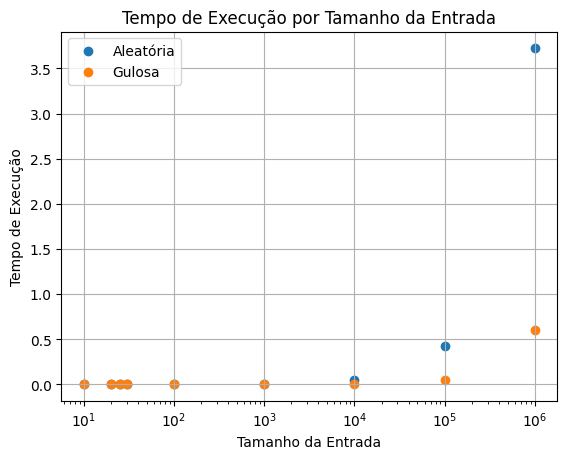

In [42]:
import json
from matplotlib import pyplot as plt

# Carregar os dados do arquivo JSON
with open("./data/output/aleatorio/results.json", 'r') as file:
    data_aleatorio = json.load(file)

with open("./data/output/heuristica/results.json", 'r') as file:
    data_heuristica = json.load(file)

# Separar os dados das duas heurísticas
heuristica1 = []
heuristica2 = []

for item in data_aleatorio:
    if item['k'] == '3':
        heuristica1.append((int(item['n']), item['time']))
for item in data_heuristica:
    if item['k'] == '3':
        heuristica2.append((int(item['n']), item['time']))

# Ordenar os dados por tamanho da entrada (X)
heuristica1 = sorted(heuristica1, key=lambda x: x[0])
heuristica2 = sorted(heuristica2, key=lambda x: x[0])

# Extrair os valores de X e Y para cada heurística
x1, y1 = zip(*heuristica1)
x2, y2 = zip(*heuristica2)

# Plotar o gráfico
plt.scatter(x1, y1,  label='Aleatória')
plt.scatter(x2, y2,  label='Gulosa')

plt.xlabel('Tamanho da Entrada')
plt.ylabel('Tempo de Execução')
plt.title('Tempo de Execução por Tamanho da Entrada')

plt.xscale('log')
plt.legend()
plt.grid(True)

plt.show()


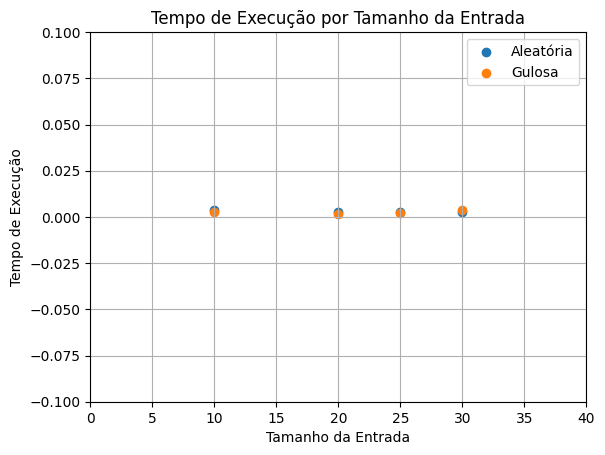

In [23]:
# Plotar o gráfico
plt.scatter(x1, y1,  label='Aleatória')
plt.scatter(x2, y2,  label='Gulosa')

plt.xlabel('Tamanho da Entrada')
plt.ylabel('Tempo de Execução')
plt.title('Tempo de Execução por Tamanho da Entrada')

plt.legend()
plt.grid(True)

plt.axis([0, 40, -0.1, 0.1])
plt.show()

Percebe-se que, no geral, a Gulosa performa praticamente igual à aleatória quando os números são pequenos, porém ela é melhor que quando o tamanho da entrada aumenta. Isso se deve ao fato de que a Aleatória não leva em consideração o tempo de término do filme anterior, o que pode gerar um desperdício de tempo de tela.

Podemos, ainda, analisar o efeito das categorias sobre uma determinada heurística

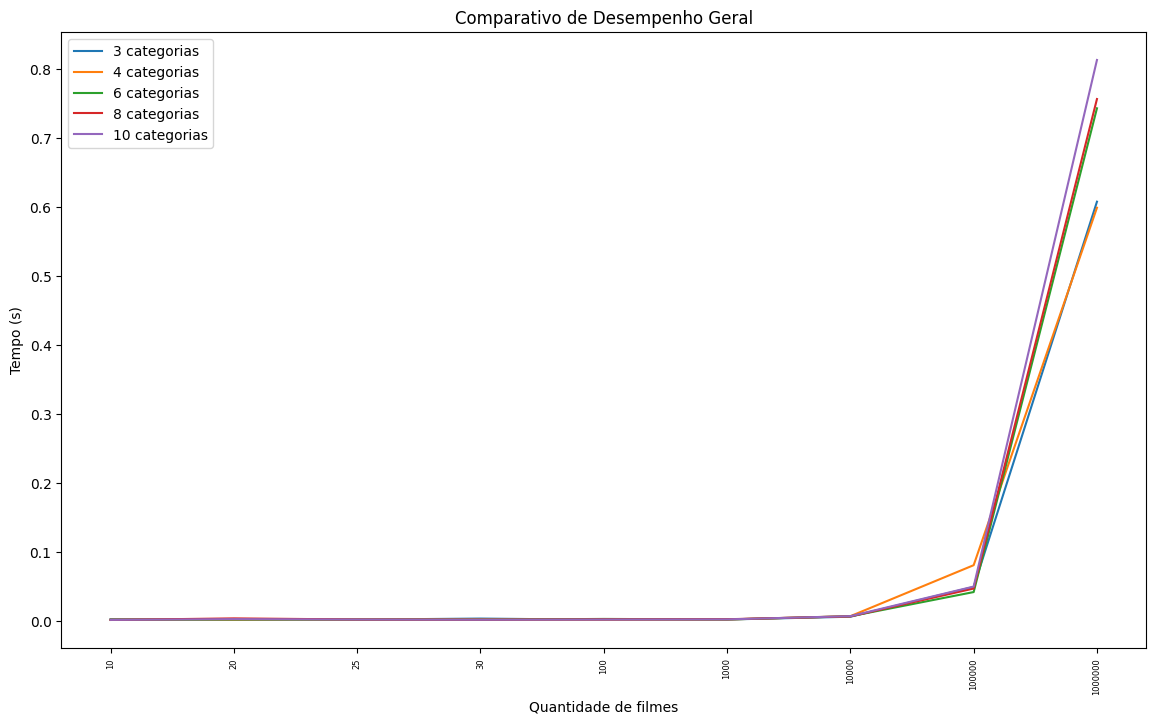

In [44]:
import json
import pandas as pd
import matplotlib.pyplot as plt


with open("./data/output/heuristica/results.json") as f:
    results_gulosa = json.load(f)
        
df = pd.DataFrame(results_gulosa)

categories = df['k'].unique()

plt.figure(figsize=(14,8))


for cat in categories:

    results_by_category = df[df['k'] == cat]
    n_movies = results_by_category['n'].to_list()
    time = results_by_category['time'].to_list()

    plt.plot(n_movies, time, label=f'{cat} categorias')
    

plt.title("Comparativo de Desempenho Geral")
plt.ylabel("Tempo (s)")
plt.xlabel("Quantidade de filmes")
plt.xticks(fontsize=6, rotation=90)
plt.legend()

## Análise do Valgrind
---

```
--------------------------------------------------------------------------------
Profile data file 'callgrind.out.26420' (creator: callgrind-3.18.1)
--------------------------------------------------------------------------------
I1 cache: 
D1 cache: 
LL cache: 
Timerange: Basic block 0 - 466446
Trigger: Program termination
Profiled target:  ./heuristica output.txt (PID 26420, part 1)
Events recorded:  Ir
Events shown:     Ir
Event sort order: Ir
Thresholds:       99
Include dirs:     
User annotated:   heuristica.cpp
Auto-annotation:  on

--------------------------------------------------------------------------------
Ir                 
--------------------------------------------------------------------------------
2,797,192 (100.0%)  PROGRAM TOTALS

--------------------------------------------------------------------------------
Ir                file:function
--------------------------------------------------------------------------------
998,266 (35.69%)  ./elf/./elf/dl-lookup.c:_dl_lookup_symbol_x [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
577,971 (20.66%)  ./elf/./elf/dl-lookup.c:do_lookup_x [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
260,826 ( 9.32%)  ./elf/../sysdeps/x86_64/dl-machine.h:_dl_relocate_object
120,813 ( 4.32%)  ./elf/./elf/dl-lookup.c:check_match [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
108,666 ( 3.88%)  ./elf/./elf/do-rel.h:_dl_relocate_object
 75,920 ( 2.71%)  ./string/../sysdeps/x86_64/strcmp.S:strcmp [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
 73,408 ( 2.62%)  ???:std::istreambuf_iterator<char, std::char_traits<char> > std::num_get<char, std::istreambuf_iterator<char, std::char_traits<char> > >::_M_extract_int<long>(std::istreambuf_iterator<char, std::char_traits<char> >, std::istreambuf_iterator<char, std::char_traits<char> >, std::ios_base&, std::_Ios_Iostate&, long&) const [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
 58,422 ( 2.09%)  ./libio/./libio/getc.c:getc [/usr/lib/x86_64-linux-gnu/libc.so.6]
 42,237 ( 1.51%)  ./libio/./libio/genops.c:_IO_sputbackc [/usr/lib/x86_64-linux-gnu/libc.so.6]
 40,014 ( 1.43%)  ./libio/./libio/ioungetc.c:ungetc [/usr/lib/x86_64-linux-gnu/libc.so.6]
 28,363 ( 1.01%)  ???:std::istream::sentry::sentry(std::istream&, bool) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
 23,540 ( 0.84%)  ./elf/./elf/dl-tunables.c:__GI___tunables_init [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
 20,094 ( 0.72%)  ./elf/../sysdeps/generic/dl-protected.h:do_lookup_x
 20,007 ( 0.72%)  ???:__gnu_cxx::stdio_sync_filebuf<char, std::char_traits<char> >::underflow() [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
 16,740 ( 0.60%)  ???:std::istream::operator>>(int&) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
 15,213 ( 0.54%)  /usr/include/c++/11/bits/stl_algobase.h:is_movie_available(std::vector<int, std::allocator<int> >&, std::vector<int, std::allocator<int> >&, std::vector<int, std::allocator<int> >&, std::vector<movie, std::allocator<movie> >&, int, int)
 12,250 ( 0.44%)  ./elf/./elf/dl-version.c:_dl_check_map_versions [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
 12,128 ( 0.43%)  ???:std::locale::_Impl::_M_install_facet(std::locale::id const*, std::locale::facet const*) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
 12,090 ( 0.43%)  ???:0x000000000012f9e0 [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
 12,056 ( 0.43%)  ???:std::ostream::flush() [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
 11,105 ( 0.40%)  ./elf/../sysdeps/generic/ldsodefs.h:do_lookup_x
 10,722 ( 0.38%)  ./elf/./elf/dl-runtime.c:_dl_fixup [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
 10,240 ( 0.37%)  ./wcsmbs/./wcsmbs/btowc.c:btowc [/usr/lib/x86_64-linux-gnu/libc.so.6]
 10,197 ( 0.36%)  ./elf/../sysdeps/generic/ldsodefs.h:_dl_relocate_object
  9,600 ( 0.34%)  ./libio/./libio/iofflush.c:fflush [/usr/lib/x86_64-linux-gnu/libc.so.6]
  8,747 ( 0.31%)  ???:std::ostream::sentry::sentry(std::ostream&) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  7,798 ( 0.28%)  heuristica.cpp:is_movie_available(std::vector<int, std::allocator<int> >&, std::vector<int, std::allocator<int> >&, std::vector<int, std::allocator<int> >&, std::vector<movie, std::allocator<movie> >&, int, int) [/home/megatron/Downloads/heuristica]
  7,119 ( 0.25%)  ???:0x000000000012b140 [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  6,816 ( 0.24%)  ???:__gnu_cxx::stdio_sync_filebuf<char, std::char_traits<char> >::uflow() [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  6,155 ( 0.22%)  ???:0x00000000048fb420 [???]
  5,786 ( 0.21%)  ./libio/./libio/fileops.c:_IO_file_sync@@GLIBC_2.2.5 [/usr/lib/x86_64-linux-gnu/libc.so.6]
  5,760 ( 0.21%)  ./libio/./libio/libioP.h:fflush
  5,580 ( 0.20%)  ???:0x00000000001032d0 [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  5,071 ( 0.18%)  /usr/include/c++/11/bits/predefined_ops.h:is_movie_available(std::vector<int, std::allocator<int> >&, std::vector<int, std::allocator<int> >&, std::vector<int, std::allocator<int> >&, std::vector<movie, std::allocator<movie> >&, int, int)
  4,674 ( 0.17%)  ./elf/../sysdeps/x86_64/dl-trampoline.h:_dl_runtime_resolve_xsave [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  4,451 ( 0.16%)  ???:0x00000000048f8a20 [???]
  4,229 ( 0.15%)  heuristica.cpp:main [/home/megatron/Downloads/heuristica]
  4,164 ( 0.15%)  ./elf/./elf/dl-reloc.c:_dl_relocate_object [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  3,782 ( 0.14%)  ./elf/./elf/dl-load.c:_dl_map_object_from_fd [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  3,456 ( 0.12%)  ./wcsmbs/./wcsmbs/wctob.c:wctob [/usr/lib/x86_64-linux-gnu/libc.so.6]
  3,410 ( 0.12%)  ???:__dynamic_cast [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  3,366 ( 0.12%)  ./elf/./elf/dl-cache.c:_dl_cache_libcmp [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  3,223 ( 0.12%)  /usr/include/c++/11/bits/stl_iterator.h:is_movie_available(std::vector<int, std::allocator<int> >&, std::vector<int, std::allocator<int> >&, std::vector<int, std::allocator<int> >&, std::vector<movie, std::allocator<movie> >&, int, int)
  3,210 ( 0.11%)  ???:std::locale::id::_M_id() const [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  3,085 ( 0.11%)  ./elf/../sysdeps/x86/dl-cacheinfo.h:intel_check_word.constprop.0 [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  2,848 ( 0.10%)  ./elf/./elf/dl-misc.c:_dl_name_match_p [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  2,796 ( 0.10%)  ./malloc/./malloc/malloc.c:_int_malloc [/usr/lib/x86_64-linux-gnu/libc.so.6]
  2,733 ( 0.10%)  ???:std::ctype<wchar_t>::_M_initialize_ctype() [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  2,604 ( 0.09%)  ???:std::ostreambuf_iterator<char, std::char_traits<char> > std::num_put<char, std::ostreambuf_iterator<char, std::char_traits<char> > >::_M_insert_int<long>(std::ostreambuf_iterator<char, std::char_traits<char> >, std::ios_base&, char, long) const [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  2,423 ( 0.09%)  ???:std::basic_filebuf<char, std::char_traits<char> >::xsputn(char const*, long) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  2,259 ( 0.08%)  ???:std::basic_streambuf<char, std::char_traits<char> >::xsputn(char const*, long) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  2,243 ( 0.08%)  ./elf/./elf/dl-load.c:_dl_map_object [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  2,226 ( 0.08%)  ./elf/./elf/dl-deps.c:_dl_map_object_deps [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  2,222 ( 0.08%)  ./elf/../bits/stdlib-bsearch.h:intel_check_word.constprop.0
  2,136 ( 0.08%)  heuristica.cpp:read_movies_booking(int, std::vector<movie, std::allocator<movie> >&) [/home/megatron/Downloads/heuristica]
  1,957 ( 0.07%)  ./elf/./elf/dl-tunables.h:__GI___tunables_init
  1,850 ( 0.07%)  ???:__cxxabiv1::__si_class_type_info::__do_dyncast(long, __cxxabiv1::__class_type_info::__sub_kind, __cxxabiv1::__class_type_info const*, void const*, __cxxabiv1::__class_type_info const*, void const*, __cxxabiv1::__class_type_info::__dyncast_result&) const [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  1,680 ( 0.06%)  ???:std::basic_ostream<char, std::char_traits<char> >& std::__ostream_insert<char, std::char_traits<char> >(std::basic_ostream<char, std::char_traits<char> >&, char const*, long) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  1,622 ( 0.06%)  ./malloc/./malloc/malloc.c:_int_free [/usr/lib/x86_64-linux-gnu/libc.so.6]
  1,614 ( 0.06%)  ???:std::ostream& std::ostream::_M_insert<long>(long) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
  1,577 ( 0.06%)  /usr/include/c++/11/bits/stl_algo.h:main
  1,513 ( 0.05%)  ./elf/./elf/dl-load.c:open_verify.constprop.0 [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  1,492 ( 0.05%)  ./elf/./elf/get-dynamic-info.h:_dl_map_object_from_fd
  1,423 ( 0.05%)  ./string/../sysdeps/x86_64/multiarch/memmove-vec-unaligned-erms.S:__memcpy_avx_unaligned_erms [/usr/lib/x86_64-linux-gnu/libc.so.6]
  1,308 ( 0.05%)  ./elf/./elf/rtld.c:dl_main [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  1,266 ( 0.05%)  ./elf/./elf/dl-load.c:open_path [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  1,256 ( 0.04%)  ./elf/./elf/dl-cache.c:_dl_load_cache_lookup [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  1,129 ( 0.04%)  ./elf/./elf/dl-object.c:_dl_new_object [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  1,115 ( 0.04%)  ./elf/./elf/dl-minimal-malloc.c:__minimal_malloc [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
  1,113 ( 0.04%)  ./malloc/./malloc/malloc.c:malloc [/usr/lib/x86_64-linux-gnu/libc.so.6]
  1,095 ( 0.04%)  ./string/../sysdeps/x86_64/multiarch/memcmp-avx2-movbe.S:__memcmp_avx2_movbe [/usr/lib/x86_64-linux-gnu/libc.so.6]
  1,068 ( 0.04%)  /usr/include/c++/11/bits/stl_algo.h:void std::__introsort_loop<__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}> >(__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, __gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}>)'2
  1,036 ( 0.04%)  ./wctype/./wctype/wctype_l.c:wctype_l [/usr/lib/x86_64-linux-gnu/libc.so.6]
    990 ( 0.04%)  ???:0x000000000012e7e0 [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
    966 ( 0.03%)  ./string/../sysdeps/x86_64/multiarch/strlen-avx2.S:__strlen_avx2 [/usr/lib/x86_64-linux-gnu/libc.so.6]
    945 ( 0.03%)  ???:__gnu_cxx::stdio_sync_filebuf<char, std::char_traits<char> >::sync() [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
    940 ( 0.03%)  /usr/include/c++/11/bits/stl_vector.h:main
    931 ( 0.03%)  ???:0x00000000048f86d0 [???]
    896 ( 0.03%)  ./wcsmbs/./wcsmbsload.h:btowc
    883 ( 0.03%)  ./elf/../sysdeps/x86_64/dl-machine.h:_dl_start
    876 ( 0.03%)  ???:__cxxabiv1::__vmi_class_type_info::__do_dyncast(long, __cxxabiv1::__class_type_info::__sub_kind, __cxxabiv1::__class_type_info const*, void const*, __cxxabiv1::__class_type_info const*, void const*, __cxxabiv1::__class_type_info::__dyncast_result&) const [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
    816 ( 0.03%)  ./string/../sysdeps/x86_64/multiarch/memset-vec-unaligned-erms.S:memset [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    815 ( 0.03%)  ./elf/./elf/do-rel.h:_dl_start
    797 ( 0.03%)  ./string/../sysdeps/x86_64/multiarch/strlen-vec.S:strlen [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    776 ( 0.03%)  ./malloc/./malloc/malloc.c:ptmalloc_init.part.0
    774 ( 0.03%)  ./elf/../sysdeps/nptl/dl-tls_init_tp.c:rtld_mutex_dummy [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    768 ( 0.03%)  ./elf/./elf/dl-hwcaps.c:_dl_important_hwcaps [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    768 ( 0.03%)  ./elf/./elf/dl-profstub.c:_dl_mcount_wrapper_check [/usr/lib/x86_64-linux-gnu/libc.so.6]
    768 ( 0.03%)  ./iconv/./iconv/gconv_simple.c:__gconv_btwoc_ascii [/usr/lib/x86_64-linux-gnu/libc.so.6]
    765 ( 0.03%)  ???:0x00000000048fb220 [???]
    744 ( 0.03%)  ./string/../sysdeps/x86_64/multiarch/../strchr.S:index [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    740 ( 0.03%)  ./elf/./elf/dl-tunables.c:__tunable_get_val [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    732 ( 0.03%)  ???:std::ctype<char>::_M_widen_init() const [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
    715 ( 0.03%)  ./elf/./dl-map-segments.h:_dl_map_object_from_fd
    705 ( 0.03%)  ./stdlib/./stdlib/cxa_finalize.c:__cxa_finalize [/usr/lib/x86_64-linux-gnu/libc.so.6]
    668 ( 0.02%)  /usr/include/c++/11/bits/stl_algo.h:void std::__introsort_loop<__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}> >(__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, __gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}>)
    666 ( 0.02%)  ???:std::locale::_Impl::_Impl(unsigned long) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
    645 ( 0.02%)  ???:0x00000000048fb360 [???]
    639 ( 0.02%)  ???:0x00000000048f9790 [???]
    629 ( 0.02%)  ./string/../sysdeps/x86_64/multiarch/memmove-vec-unaligned-erms.S:mempcpy [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    625 ( 0.02%)  ???:0x00000000048f9160 [???]
    625 ( 0.02%)  ???:0x00000000048fa9c0 [???]
    620 ( 0.02%)  ???:0x000000000010a220 [???]
    620 ( 0.02%)  ???:std::num_get<char, std::istreambuf_iterator<char, std::char_traits<char> > >::do_get(std::istreambuf_iterator<char, std::char_traits<char> >, std::istreambuf_iterator<char, std::char_traits<char> >, std::ios_base&, std::_Ios_Iostate&, long&) const [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
    600 ( 0.02%)  /usr/include/c++/11/bits/stl_vector.h:is_movie_available(std::vector<int, std::allocator<int> >&, std::vector<int, std::allocator<int> >&, std::vector<int, std::allocator<int> >&, std::vector<movie, std::allocator<movie> >&, int, int)
    596 ( 0.02%)  ./elf/../sysdeps/x86/dl-cacheinfo.h:handle_intel.constprop.0 [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    594 ( 0.02%)  ./string/../sysdeps/x86_64/multiarch/memmove-vec-unaligned-erms.S:memcpy [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    588 ( 0.02%)  /usr/include/c++/11/bits/predefined_ops.h:main
    530 ( 0.02%)  ./elf/./elf/dl-sort-maps.c:dfs_traversal.part.0 [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    528 ( 0.02%)  ./malloc/./malloc/malloc.c:free [/usr/lib/x86_64-linux-gnu/libc.so.6]
    522 ( 0.02%)  ???:std::ios_base::ios_base() [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
    517 ( 0.02%)  ???:0x00000000048faa90 [???]
    516 ( 0.02%)  /usr/include/c++/11/bits/stl_vector.h:read_movies_booking(int, std::vector<movie, std::allocator<movie> >&)
    502 ( 0.02%)  ./elf/../sysdeps/x86/dl-prop.h:_dl_map_object_from_fd
    489 ( 0.02%)  heuristica.cpp:void std::__introsort_loop<__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}> >(__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, __gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}>)'2
    477 ( 0.02%)  ./elf/../elf/dl-sysdep.c:_dl_sysdep_start [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    442 ( 0.02%)  ???:std::locale::locale() [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
    437 ( 0.02%)  ./elf/./elf/dl-hwcaps_split.c:_dl_hwcaps_split_masked [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    436 ( 0.02%)  ./elf/./dl-find_object.h:_dl_find_object_from_map [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    429 ( 0.02%)  ./stdlib/./stdlib/cxa_atexit.c:__cxa_atexit [/usr/lib/x86_64-linux-gnu/libc.so.6]
    422 ( 0.02%)  /usr/include/c++/11/bits/predefined_ops.h:void std::__introsort_loop<__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}> >(__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, __gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}>)'2
    420 ( 0.02%)  ./elf/./elf/dl-error-skeleton.c:_dl_catch_exception [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    414 ( 0.01%)  ./elf/./elf/dl-fini.c:_dl_fini [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    414 ( 0.01%)  ???:std::__cxx11::numpunct<char>::_M_initialize_numpunct(__locale_struct*) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
    414 ( 0.01%)  ???:std::numpunct<char>::_M_initialize_numpunct(__locale_struct*) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
    413 ( 0.01%)  ./elf/./elf/dl-init.c:call_init.part.0 [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    400 ( 0.01%)  ./io/../sysdeps/unix/sysv/linux/open64_nocancel.c:__open_nocancel [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    392 ( 0.01%)  ./stdlib/./stdlib/cxa_atexit.c:__new_exitfn [/usr/lib/x86_64-linux-gnu/libc.so.6]
    356 ( 0.01%)  /usr/include/c++/11/bits/stl_iterator.h:void std::__introsort_loop<__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}> >(__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, __gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}>)'2 [/home/megatron/Downloads/heuristica]
    350 ( 0.01%)  ./elf/../elf/dl-tls.c:_dl_allocate_tls_storage [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    350 ( 0.01%)  ???:std::__cxx11::numpunct<wchar_t>::_M_initialize_numpunct(__locale_struct*) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
    350 ( 0.01%)  ???:std::numpunct<wchar_t>::_M_initialize_numpunct(__locale_struct*) [/usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.30]
    346 ( 0.01%)  /usr/include/c++/11/bits/stl_iterator.h:main
    344 ( 0.01%)  ./elf/./elf/dl-sort-maps.c:_dl_sort_maps [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    342 ( 0.01%)  ./elf/./get-dynamic-info.h:dl_main
    337 ( 0.01%)  ./elf/./elf/dl-environ.c:_dl_next_ld_env_entry [/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2]
    332 ( 0.01%)  /usr/include/c++/11/bits/vector.tcc:void std::vector<int, std::allocator<int> >::_M_realloc_insert<int const&>(__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, int const&) [/home/megatron/Downloads/heuristica]
    332 ( 0.01%)  heuristica.cpp:void std::__introsort_loop<__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}> >(__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, __gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}>)
    315 ( 0.01%)  ???:0x0000000000003740 [/usr/lib/x86_64-linux-gnu/libgcc_s.so.1]

--------------------------------------------------------------------------------
-- Auto-annotated source: /usr/include/c++/11/bits/stl_vector.h
--------------------------------------------------------------------------------
Ir           

-- line 90 ----------------------------------------
  .           
  .                 struct _Vector_impl_data
  .                 {
  .           	pointer _M_start;
  .           	pointer _M_finish;
  .           	pointer _M_end_of_storage;
  .           
  .           	_Vector_impl_data() _GLIBCXX_NOEXCEPT
 14 ( 0.00%)  	: _M_start(), _M_finish(), _M_end_of_storage()
  .           	{ }
  .           
  .           #if __cplusplus >= 201103L
  .           	_Vector_impl_data(_Vector_impl_data&& __x) noexcept
  .           	: _M_start(__x._M_start), _M_finish(__x._M_finish),
  .           	  _M_end_of_storage(__x._M_end_of_storage)
  .           	{ __x._M_start = __x._M_finish = __x._M_end_of_storage = pointer(); }
  .           #endif
-- line 106 ----------------------------------------
-- line 328 ----------------------------------------
  .                 _Vector_base(const allocator_type& __a, _Vector_base&& __x)
  .                 : _M_impl(_Tp_alloc_type(__a), std::move(__x._M_impl))
  .                 { }
  .           #endif
  .           
  .                 ~_Vector_base() _GLIBCXX_NOEXCEPT
  .                 {
  .           	_M_deallocate(_M_impl._M_start,
 14 ( 0.00%)  		      _M_impl._M_end_of_storage - _M_impl._M_start);
  .                 }
  .           
  .               public:
  .                 _Vector_impl _M_impl;
  .           
  .                 pointer
  .                 _M_allocate(size_t __n)
  .                 {
  .           	typedef __gnu_cxx::__alloc_traits<_Tp_alloc_type> _Tr;
 44 ( 0.00%)  	return __n != 0 ? _Tr::allocate(_M_impl, __n) : pointer();
  .                 }
  .           
  .                 void
  .                 _M_deallocate(pointer __p, size_t __n)
  .                 {
  .           	typedef __gnu_cxx::__alloc_traits<_Tp_alloc_type> _Tr;
 22 ( 0.00%)  	if (__p)
  .           	  _Tr::deallocate(_M_impl, __p, __n);
  .                 }
  .           
  .               protected:
  .                 void
  .                 _M_create_storage(size_t __n)
  .                 {
  .           	this->_M_impl._M_start = this->_M_allocate(__n);
-- line 361 ----------------------------------------
-- line 672 ----------------------------------------
  .                 /**
  .                  *  The dtor only erases the elements, and note that if the
  .                  *  elements themselves are pointers, the pointed-to memory is
  .                  *  not touched in any way.  Managing the pointer is the user's
  .                  *  responsibility.
  .                  */
  .                 ~vector() _GLIBCXX_NOEXCEPT
  .                 {
  4 ( 0.00%)  	std::_Destroy(this->_M_impl._M_start, this->_M_impl._M_finish,
  .           		      _M_get_Tp_allocator());
  .           	_GLIBCXX_ASAN_ANNOTATE_BEFORE_DEALLOC;
  .                 }
  .           
  .                 /**
  .                  *  @brief  %Vector assignment operator.
  .                  *  @param  __x  A %vector of identical element and allocator types.
  .                  *
-- line 688 ----------------------------------------
-- line 911 ----------------------------------------
  .                 crend() const noexcept
  .                 { return const_reverse_iterator(begin()); }
  .           #endif
  .           
  .                 // [23.2.4.2] capacity
  .                 /**  Returns the number of elements in the %vector.  */
  .                 size_type
  .                 size() const _GLIBCXX_NOEXCEPT
 67 ( 0.00%)        { return size_type(this->_M_impl._M_finish - this->_M_impl._M_start); }
  .           
  .                 /**  Returns the size() of the largest possible %vector.  */
  .                 size_type
  .                 max_size() const _GLIBCXX_NOEXCEPT
  .                 { return _S_max_size(_M_get_Tp_allocator()); }
  .           
  .           #if __cplusplus >= 201103L
  .                 /**
-- line 927 ----------------------------------------
-- line 992 ----------------------------------------
  .           
  .                 /**
  .                  *  Returns the total number of elements that the %vector can
  .                  *  hold before needing to allocate more memory.
  .                  */
  .                 size_type
  .                 capacity() const _GLIBCXX_NOEXCEPT
  .                 { return size_type(this->_M_impl._M_end_of_storage
 10 ( 0.00%)  			 - this->_M_impl._M_start); }
  .           
  .                 /**
  .                  *  Returns true if the %vector is empty.  (Thus begin() would
  .                  *  equal end().)
  .                  */
  .                 _GLIBCXX_NODISCARD bool
  .                 empty() const _GLIBCXX_NOEXCEPT
  .                 { return begin() == end(); }
-- line 1008 ----------------------------------------
-- line 1038 ----------------------------------------
  .                  *  Note that data access with this operator is unchecked and
  .                  *  out_of_range lookups are not defined. (For checked lookups
  .                  *  see at().)
  .                  */
  .                 reference
  .                 operator[](size_type __n) _GLIBCXX_NOEXCEPT
  .                 {
  .           	__glibcxx_requires_subscript(__n);
896 ( 0.03%)  	return *(this->_M_impl._M_start + __n);
  .                 }
  .           
  .                 /**
  .                  *  @brief  Subscript access to the data contained in the %vector.
  .                  *  @param __n The index of the element for which data should be
  .                  *  accessed.
  .                  *  @return  Read-only (constant) reference to data.
  .                  *
-- line 1054 ----------------------------------------
-- line 1181 ----------------------------------------
  .                  *  element at the end of the %vector and assigns the given data
  .                  *  to it.  Due to the nature of a %vector this operation can be
  .                  *  done in constant time if the %vector has preallocated space
  .                  *  available.
  .                  */
  .                 void
  .                 push_back(const value_type& __x)
  .                 {
644 ( 0.02%)  	if (this->_M_impl._M_finish != this->_M_impl._M_end_of_storage)
  .           	  {
  .           	    _GLIBCXX_ASAN_ANNOTATE_GROW(1);
  .           	    _Alloc_traits::construct(this->_M_impl, this->_M_impl._M_finish,
  .           				     __x);
456 ( 0.02%)  	    ++this->_M_impl._M_finish;
  .           	    _GLIBCXX_ASAN_ANNOTATE_GREW(1);
  .           	  }
  .           	else
 66 ( 0.00%)  	  _M_realloc_insert(end(), __x);
4,635 ( 0.17%)  => /usr/include/c++/11/bits/vector.tcc:void std::vector<movie, std::allocator<movie> >::_M_realloc_insert<movie const&>(__gnu_cxx::__normal_iterator<movie*, std::vector<movie, std::allocator<movie> > >, movie const&) (8x)
  .                 }
  .           
  .           #if __cplusplus >= 201103L
  .                 void
  .                 push_back(value_type&& __x)
  .                 { emplace_back(std::move(__x)); }
  .           
  .                 template<typename... _Args>
-- line 1206 ----------------------------------------
-- line 1750 ----------------------------------------
  .                 _M_emplace_aux(const_iterator __position, value_type&& __v)
  .                 { return _M_insert_rval(__position, std::move(__v)); }
  .           #endif
  .           
  .                 // Called by _M_fill_insert, _M_insert_aux etc.
  .                 size_type
  .                 _M_check_len(size_type __n, const char* __s) const
  .                 {
200 ( 0.01%)  	if (max_size() - size() < __n)
  .           	  __throw_length_error(__N(__s));
  .           
  .           	const size_type __len = size() + (std::max)(size(), __n);
 40 ( 0.00%)  	return (__len < size() || __len > max_size()) ? max_size() : __len;
  .                 }
  .           
  .                 // Called by constructors to check initial size.
  .                 static size_type
  .                 _S_check_init_len(size_type __n, const allocator_type& __a)
  .                 {
  .           	if (__n > _S_max_size(_Tp_alloc_type(__a)))
  .           	  __throw_length_error(
-- line 1770 ----------------------------------------

--------------------------------------------------------------------------------
-- Auto-annotated source: /usr/include/c++/11/bits/stl_algo.h
--------------------------------------------------------------------------------
Ir           

-- line 74 ----------------------------------------
  .           
  .             /// Swaps the median value of *__a, *__b and *__c under __comp to *__result
  .             template<typename _Iterator, typename _Compare>
  .               _GLIBCXX20_CONSTEXPR
  .               void
  .               __move_median_to_first(_Iterator __result,_Iterator __a, _Iterator __b,
  .           			   _Iterator __c, _Compare __comp)
  .               {
 18 ( 0.00%)        if (__comp(__a, __b))
  .           	{
  6 ( 0.00%)  	  if (__comp(__b, __c))
  .           	    std::iter_swap(__result, __b);
  6 ( 0.00%)  	  else if (__comp(__a, __c))
  .           	    std::iter_swap(__result, __c);
  .           	  else
  .           	    std::iter_swap(__result, __a);
  .           	}
 12 ( 0.00%)        else if (__comp(__a, __c))
  .           	std::iter_swap(__result, __a);
  6 ( 0.00%)        else if (__comp(__b, __c))
  .           	std::iter_swap(__result, __c);
  .                 else
  .           	std::iter_swap(__result, __b);
  .               }
  .           
  .             /// Provided for stable_partition to use.
  .             template<typename _InputIterator, typename _Predicate>
  .               _GLIBCXX20_CONSTEXPR
-- line 101 ----------------------------------------
-- line 1791 ----------------------------------------
  .           				      __result_first, __result_last,
  .           				__gnu_cxx::__ops::__iter_comp_iter(__comp));
  .               }
  .           
  .             /// This is a helper function for the sort routine.
  .             template<typename _RandomAccessIterator, typename _Compare>
  .               _GLIBCXX20_CONSTEXPR
  .               void
 84 ( 0.00%)      __unguarded_linear_insert(_RandomAccessIterator __last,
  .           			      _Compare __comp)
  .               {
  .                 typename iterator_traits<_RandomAccessIterator>::value_type
168 ( 0.01%)  	__val = _GLIBCXX_MOVE(*__last);
  .                 _RandomAccessIterator __next = __last;
  .                 --__next;
922 ( 0.03%)        while (__comp(__val, __next))
  .           	{
192 ( 0.01%)  	  *__last = _GLIBCXX_MOVE(*__next);
  .           	  __last = __next;
  .           	  --__next;
  .           	}
101 ( 0.00%)        *__last = _GLIBCXX_MOVE(__val);
  .               }
  .           
  .             /// This is a helper function for the sort routine.
  .             template<typename _RandomAccessIterator, typename _Compare>
  .               _GLIBCXX20_CONSTEXPR
  .               void
  9 ( 0.00%)      __insertion_sort(_RandomAccessIterator __first,
  .           		     _RandomAccessIterator __last, _Compare __comp)
  .               {
  2 ( 0.00%)        if (__first == __last) return;
  .           
 33 ( 0.00%)        for (_RandomAccessIterator __i = __first + 1; __i != __last; ++__i)
  .           	{
 30 ( 0.00%)  	  if (__comp(__i, __first))
  .           	    {
  .           	      typename iterator_traits<_RandomAccessIterator>::value_type
  .           		__val = _GLIBCXX_MOVE(*__i);
  .           	      _GLIBCXX_MOVE_BACKWARD3(__first, __i, __i + 1);
  1 ( 0.00%)  	      *__first = _GLIBCXX_MOVE(__val);
  .           	    }
  .           	  else
  .           	    std::__unguarded_linear_insert(__i,
  .           				__gnu_cxx::__ops::__val_comp_iter(__comp));
  .           	}
  8 ( 0.00%)      }
  .           
  .             /// This is a helper function for the sort routine.
  .             template<typename _RandomAccessIterator, typename _Compare>
  .               _GLIBCXX20_CONSTEXPR
  .               inline void
  .               __unguarded_insertion_sort(_RandomAccessIterator __first,
  .           			       _RandomAccessIterator __last, _Compare __comp)
  .               {
254 ( 0.01%)        for (_RandomAccessIterator __i = __first; __i != __last; ++__i)
  .           	std::__unguarded_linear_insert(__i,
  .           				__gnu_cxx::__ops::__val_comp_iter(__comp));
  .               }
  .           
  .             /**
  .              *  @doctodo
  .              *  This controls some aspect of the sort routines.
  .             */
-- line 1854 ----------------------------------------
-- line 1856 ----------------------------------------
  .           
  .             /// This is a helper function for the sort routine.
  .             template<typename _RandomAccessIterator, typename _Compare>
  .               _GLIBCXX20_CONSTEXPR
  .               void
  .               __final_insertion_sort(_RandomAccessIterator __first,
  .           			   _RandomAccessIterator __last, _Compare __comp)
  .               {
  2 ( 0.00%)        if (__last - __first > int(_S_threshold))
  .           	{
  3 ( 0.00%)  	  std::__insertion_sort(__first, __first + int(_S_threshold), __comp);
576 ( 0.02%)  => /usr/include/c++/11/bits/stl_algo.h:void std::__insertion_sort<__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}> >(__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, __gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}>) (1x)
  .           	  std::__unguarded_insertion_sort(__first + int(_S_threshold), __last,
  .           					  __comp);
  .           	}
  .                 else
  .           	std::__insertion_sort(__first, __last, __comp);
  .               }
  .           
  .             /// This is a helper function...
  .             template<typename _RandomAccessIterator, typename _Compare>
  .               _GLIBCXX20_CONSTEXPR
  .               _RandomAccessIterator
 27 ( 0.00%)      __unguarded_partition(_RandomAccessIterator __first,
  .           			  _RandomAccessIterator __last,
  .           			  _RandomAccessIterator __pivot, _Compare __comp)
  .               {
  .                 while (true)
  .           	{
563 ( 0.02%)  	  while (__comp(__first, __pivot))
  .           	    ++__first;
  .           	  --__last;
691 ( 0.02%)  	  while (__comp(__pivot, __last))
  .           	    --__last;
178 ( 0.01%)  	  if (!(__first < __last))
  .           	    return __first;
  .           	  std::iter_swap(__first, __last);
  .           	  ++__first;
  .           	}
  .               }
  .           
  .             /// This is a helper function...
  .             template<typename _RandomAccessIterator, typename _Compare>
  .               _GLIBCXX20_CONSTEXPR
  .               inline _RandomAccessIterator
  .               __unguarded_partition_pivot(_RandomAccessIterator __first,
  .           				_RandomAccessIterator __last, _Compare __comp)
  .               {
 27 ( 0.00%)        _RandomAccessIterator __mid = __first + (__last - __first) / 2;
  .                 std::__move_median_to_first(__first, __first + 1, __mid, __last - 1,
  .           				  __comp);
  .                 return std::__unguarded_partition(__first + 1, __last, __first, __comp);
  .               }
  .           
  .             template<typename _RandomAccessIterator, typename _Compare>
  .               _GLIBCXX20_CONSTEXPR
  .               inline void
-- line 1911 ----------------------------------------
-- line 1917 ----------------------------------------
  .                 std::__heap_select(__first, __middle, __last, __comp);
  .                 std::__sort_heap(__first, __middle, __comp);
  .               }
  .           
  .             /// This is a helper function for the sort routine.
  .             template<typename _RandomAccessIterator, typename _Size, typename _Compare>
  .               _GLIBCXX20_CONSTEXPR
  .               void
 44 ( 0.00%)      __introsort_loop(_RandomAccessIterator __first,
  .           		     _RandomAccessIterator __last,
  .           		     _Size __depth_limit, _Compare __comp)
  .               {
 38 ( 0.00%)        while (__last - __first > int(_S_threshold))
  .           	{
 28 ( 0.00%)  	  if (__depth_limit == 0)
  .           	    {
  .           	      std::__partial_sort(__first, __last, __last, __comp);
  .           	      return;
  .           	    }
  9 ( 0.00%)  	  --__depth_limit;
  .           	  _RandomAccessIterator __cut =
  .           	    std::__unguarded_partition_pivot(__first, __last, __comp);
 45 ( 0.00%)  	  std::__introsort_loop(__cut, __last, __depth_limit, __comp);
2,470 ( 0.09%)  => /usr/include/c++/11/bits/stl_iterator.h:void std::__introsort_loop<__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}> >(__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, __gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}>)'2 (3x)
  .           	  __last = __cut;
  .           	}
 38 ( 0.00%)      }
  .           
  .             // sort
  .           
  .             template<typename _RandomAccessIterator, typename _Compare>
  .               _GLIBCXX20_CONSTEXPR
  .               inline void
  .               __sort(_RandomAccessIterator __first, _RandomAccessIterator __last,
  .           	   _Compare __comp)
  .               {
  2 ( 0.00%)        if (__first != __last)
  .           	{
  4 ( 0.00%)  	  std::__introsort_loop(__first, __last,
4,053 ( 0.14%)  => /usr/include/c++/11/bits/stl_iterator.h:void std::__introsort_loop<__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}> >(__gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, __gnu_cxx::__normal_iterator<int*, std::vector<int, std::allocator<int> > >, long, __gnu_cxx::__ops::_Iter_comp_iter<sort_book_by_ending_time(std::vector<movie, std::allocator<movie> >&, std::vector<int, std::allocator<int> >&)::{lambda(int, int)#1}>) (1x)
  .           				std::__lg(__last - __first) * 2,
  .           				__comp);
  .           	  std::__final_insertion_sort(__first, __last, __comp);
  .           	}
  .               }
  .           
  .             template<typename _RandomAccessIterator, typename _Size, typename _Compare>
  .               _GLIBCXX20_CONSTEXPR
-- line 1962 ----------------------------------------

--------------------------------------------------------------------------------
-- Auto-annotated source: /usr/include/c++/11/bits/stl_iterator.h
--------------------------------------------------------------------------------
Ir             

-- line 1003 ----------------------------------------
    .                 using iterator_concept = std::__detail::__iter_concept<_Iterator>;
    .           #endif
    .           
    .                 _GLIBCXX_CONSTEXPR __normal_iterator() _GLIBCXX_NOEXCEPT
    .                 : _M_current(_Iterator()) { }
    .           
    .                 explicit _GLIBCXX20_CONSTEXPR
    .                 __normal_iterator(const _Iterator& __i) _GLIBCXX_NOEXCEPT
1,525 ( 0.05%)        : _M_current(__i) { }
    .           
    .                 // Allow iterator to const_iterator conversion
    .                 template<typename _Iter>
    .                   _GLIBCXX20_CONSTEXPR
    .                   __normal_iterator(const __normal_iterator<_Iter,
    .           			  typename __enable_if<
    .                 	       (std::__are_same<_Iter, typename _Container::pointer>::__value),
    .           		      _Container>::__type>& __i) _GLIBCXX_NOEXCEPT
-- line 1019 ----------------------------------------
-- line 1029 ----------------------------------------
    .                 pointer
    .                 operator->() const _GLIBCXX_NOEXCEPT
    .                 { return _M_current; }
    .           
    .                 _GLIBCXX20_CONSTEXPR
    .                 __normal_iterator&
    .                 operator++() _GLIBCXX_NOEXCEPT
    .                 {
  591 ( 0.02%)  	++_M_current;
   80 ( 0.00%)  	return *this;
    .                 }
    .           
    .                 _GLIBCXX20_CONSTEXPR
    .                 __normal_iterator
    .                 operator++(int) _GLIBCXX_NOEXCEPT
    .                 { return __normal_iterator(_M_current++); }
    .           
    .                 // Bidirectional iterator requirements
    .                 _GLIBCXX20_CONSTEXPR
    .                 __normal_iterator&
  192 ( 0.01%)        operator--() _GLIBCXX_NOEXCEPT
    .                 {
  456 ( 0.02%)  	--_M_current;
    .           	return *this;
    .                 }
    .           
    .                 _GLIBCXX20_CONSTEXPR
    .                 __normal_iterator
    .                 operator--(int) _GLIBCXX_NOEXCEPT
    .                 { return __normal_iterator(_M_current--); }
    .           
-- line 1059 ----------------------------------------
-- line 1066 ----------------------------------------
    .                 _GLIBCXX20_CONSTEXPR
    .                 __normal_iterator&
    .                 operator+=(difference_type __n) _GLIBCXX_NOEXCEPT
    .                 { _M_current += __n; return *this; }
    .           
    .                 _GLIBCXX20_CONSTEXPR
    .                 __normal_iterator
    .                 operator+(difference_type __n) const _GLIBCXX_NOEXCEPT
   16 ( 0.00%)        { return __normal_iterator(_M_current + __n); }
    .           
    .                 _GLIBCXX20_CONSTEXPR
    .                 __normal_iterator&
    .                 operator-=(difference_type __n) _GLIBCXX_NOEXCEPT
    .                 { _M_current -= __n; return *this; }
    .           
    .                 _GLIBCXX20_CONSTEXPR
    .                 __normal_iterator
-- line 1082 ----------------------------------------
-- line 1229 ----------------------------------------
    .               { return __lhs.base() - __rhs.base(); }
    .           
    .             template<typename _Iterator, typename _Container>
    .               _GLIBCXX20_CONSTEXPR
    .               inline typename __normal_iterator<_Iterator, _Container>::difference_type
    .               operator-(const __normal_iterator<_Iterator, _Container>& __lhs,
    .           	      const __normal_iterator<_Iterator, _Container>& __rhs)
    .               _GLIBCXX_NOEXCEPT
1,413 ( 0.05%)      { return __lhs.base() - __rhs.base(); }
    .           
    .             template<typename _Iterator, typename _Container>
    .               _GLIBCXX20_CONSTEXPR
    .               inline __normal_iterator<_Iterator, _Container>
    .               operator+(typename __normal_iterator<_Iterator, _Container>::difference_type
    .           	      __n, const __normal_iterator<_Iterator, _Container>& __i)
    .               _GLIBCXX_NOEXCEPT
    .               { return __normal_iterator<_Iterator, _Container>(__i.base() + __n); }
-- line 1245 ----------------------------------------

--------------------------------------------------------------------------------
-- User-annotated source: heuristica.cpp
--------------------------------------------------------------------------------
Ir             

-- line 10 ----------------------------------------
    .           
    .           struct movie {
    .               int id;
    .               int start;
    .               int end;
    .               int category;
    .           };
    .           
   12 ( 0.00%)  void read_movies_booking(int size, vector<movie> &book) {
  395 ( 0.01%)      for (int i = 0; i < size; i++) {
    .                   movie m;
  100 ( 0.00%)          m.id = i;
  300 ( 0.01%)          cin >> m.start;
131,136 ( 4.69%)  => ???:0x000000000010a220 (100x)
  300 ( 0.01%)          cin >> m.end;
121,020 ( 4.33%)  => ???:0x000000000010a220 (100x)
    .           
  300 ( 0.01%)          if (m.end < m.start) {
   18 ( 0.00%)              m.end += 24; // acaba no dia seguinte
    .                   }
    .           
  100 ( 0.00%)          int category = 0;
  300 ( 0.01%)          cin >> category;
104,800 ( 3.75%)  => ???:0x000000000010a220 (100x)
    .           
  300 ( 0.01%)          m.category = category - 1;
    .           
    .                   // HARD FIX -> Alinha categoria com o índice dos arrays
    .           
    .                   book.push_back(m);
    .               }
   11 ( 0.00%)  }
    .           
    .           void sort_book_by_ending_time(vector<movie> &book, vector<int> &sorting_list) {
1,156 ( 0.04%)      sort(sorting_list.begin(), sorting_list.end(), [&](int i, int j) { return book[i].end < book[j].end; });
    .           }
    .           
    .           void book_a_movie(vector<movie> &book, vector<int> &movies_booked, vector<int> &categories_booked, int movie_id) {
    .               movies_booked.push_back(movie_id);
   18 ( 0.00%)      categories_booked.push_back(book[movie_id].category);
    .           }
    .           
2,600 ( 0.09%)  bool is_movie_available(vector<int> &movies_booked, vector<int> &categories_booked, vector<int> &categories_max_size, vector<movie> &book, int movie_id, int last_seen_finishes_at) {
    .               // checa se o filme já não foi assistido
    .               bool movie_is_taken = find(movies_booked.begin(), movies_booked.end(), movie_id) != movies_booked.end();
    .           
    .               // checa se estourou limite para categoria
1,000 ( 0.04%)      bool category_limit_exceeded = count(categories_booked.begin(), categories_booked.end(), book[movie_id].category) >= categories_max_size[book[movie_id].category];
    .           
    .               // checa se o filme anterior já acabou no horário de início do filme atual
  998 ( 0.04%)      bool is_time_available = (movies_booked.size() == 0) || (book[movie_id].start >= last_seen_finishes_at);
    .           
  400 ( 0.01%)      if (DEBUG) {
    .                   cout << "M" << movie_id << "\t" << book[movie_id].start << "~" << book[movie_id].end << " C" << book[movie_id].category;
    .           
    .                   if (!is_time_available) {
    .                       cout << "\t time is not available "
    .                            << "(" << book[movies_booked.back()].end << ")";
    .                   }
    .                   if (category_limit_exceeded) {
    .                       cout << "\t category limit exceeded";
-- line 67 ----------------------------------------
-- line 71 ----------------------------------------
    .                   }
    .                   if (!category_limit_exceeded && !movie_is_taken && is_time_available) {
    .                       cout << "\t is available";
    .                   }
    .                   cout << endl;
    .               }
    .           
    .               // passa em todos os filtros
1,200 ( 0.04%)      if (!category_limit_exceeded && !movie_is_taken && is_time_available) {
    .           
    .                   return true;
    .               }
    .           
    .               return false;
1,600 ( 0.06%)  }
    .           
   12 ( 0.00%)  int main(int argc, char *argv[]) {
    .               vector<movie> book;
    1 ( 0.00%)      int n = 0;
    1 ( 0.00%)      int k = 0;
    .           
    4 ( 0.00%)      cin >> n;
7,941 ( 0.28%)  => ???:0x000000000010a220 (1x)
    3 ( 0.00%)      cin >> k;
1,048 ( 0.04%)  => ???:0x000000000010a220 (1x)
    .           
    1 ( 0.00%)      string filename = argv[1];
    .           
    3 ( 0.00%)      ofstream inputFile;
6,453 ( 0.23%)  => ???:0x000000000010a340 (1x)
    .               inputFile.open(filename);
    .           
    .               vector<int> categories_max_size;
    4 ( 0.00%)      categories_max_size.reserve(k);
  247 ( 0.01%)  => /usr/include/c++/11/bits/vector.tcc:std::vector<int, std::allocator<int> >::reserve(unsigned long) (1x)
    .           
   30 ( 0.00%)      for (int i = 0; i < k; i++) {
    8 ( 0.00%)          int max_size = 0;
   24 ( 0.00%)          cin >> max_size;
8,505 ( 0.30%)  => ???:0x000000000010a220 (8x)
    .                   categories_max_size.push_back(max_size);
    .               }
    .           
    .               inputFile << "max_by_category: ";
   29 ( 0.00%)      for (int i = 0; i < k; i++) {
   40 ( 0.00%)          inputFile << categories_max_size[i] << " ";
7,421 ( 0.27%)  => ???:0x000000000010a350 (8x)
    .               }
    .           
    .               inputFile << endl;
    .           
    .               vector<int> movies_booked;
    .               vector<int> categories_booked;
    .           
    4 ( 0.00%)      read_movies_booking(n, book);
364,335 (13.03%)  => heuristica.cpp:read_movies_booking(int, std::vector<movie, std::allocator<movie> >&) (1x)
    .           
    .               // utilizaremos ordenação indireta
    .               vector<int> sorting_movies;
    4 ( 0.00%)      sorting_movies.reserve(n);
  243 ( 0.01%)  => /usr/include/c++/11/bits/vector.tcc:std::vector<int, std::allocator<int> >::reserve(unsigned long) (1x)
    .           
  505 ( 0.02%)      for (int i = 0; i < n; i++) {
    .                   sorting_movies.push_back(i);
    .               }
    .           
    .               sort_book_by_ending_time(book, sorting_movies);
    .           
    1 ( 0.00%)      int last_seen_finishes_at = 0;
    5 ( 0.00%)      for (int day = 0; day < 2; day++) {
  815 ( 0.03%)          for (int i = 0; i < n; i++) {
  414 ( 0.01%)              int movie_id = sorting_movies[i];
    .           
1,400 ( 0.05%)              bool is_available = is_movie_available(movies_booked, categories_booked, categories_max_size, book, movie_id, last_seen_finishes_at);
31,905 ( 1.14%)  => heuristica.cpp:is_movie_available(std::vector<int, std::allocator<int> >&, std::vector<int, std::allocator<int> >&, std::vector<int, std::allocator<int> >&, std::vector<movie, std::allocator<movie> >&, int, int) (200x)
    .           
  400 ( 0.01%)              if (is_available) {
   20 ( 0.00%)                  book_a_movie(book, movies_booked, categories_booked, movie_id);
   40 ( 0.00%)                  last_seen_finishes_at = book[movie_id].end;
    .                       }
    .                   }
    .           
    .                   if (last_seen_finishes_at >= 24) {
    6 ( 0.00%)              last_seen_finishes_at -= 24;
    .                   }
    .               }
    .           
   85 ( 0.00%)      for (uint i = 0; i < movies_booked.size(); i++) {
   80 ( 0.00%)          inputFile << movies_booked[i] << " ";
7,320 ( 0.26%)  => ???:0x000000000010a350 (20x)
    .               }
    .           
    .               inputFile << endl
    .                         << "total: " << movies_booked.size() << endl;
    .           
    .               inputFile << endl;
    .           
    2 ( 0.00%)      inputFile.close();
5,585 ( 0.20%)  => ???:0x000000000010a2f0 (1x)
    .               return 0;
   21 ( 0.00%)  }3,525 ( 0.13%)  => ???:0x000000000010a300 (1x)

--------------------------------------------------------------------------------
-- Auto-annotated source: /usr/include/c++/11/bits/stl_algobase.h
--------------------------------------------------------------------------------
Ir             

-- line 733 ----------------------------------------
    .           #if __cplusplus >= 201103L
    .           	  using __assignable = conditional<_IsMove,
    .           					   is_move_assignable<_Tp>,
    .           					   is_copy_assignable<_Tp>>;
    .           	  // trivial types can have deleted assignment
    .           	  static_assert( __assignable::type::value, "type is not assignable" );
    .           #endif
    .           	  const ptrdiff_t _Num = __last - __first;
    2 ( 0.00%)  	  if (_Num)
    7 ( 0.00%)  	    __builtin_memmove(__result - _Num, __first, sizeof(_Tp) * _Num);
   17 ( 0.00%)  => ???:0x000000000010a320 (1x)
    .           	  return __result - _Num;
    .           	}
    .               };
    .           
    .             template<bool _IsMove, typename _BI1, typename _BI2>
    .               _GLIBCXX20_CONSTEXPR
    .               inline _BI2
    .               __copy_move_backward_a2(_BI1 __first, _BI1 __last, _BI2 __result)
-- line 750 ----------------------------------------
-- line 1507 ----------------------------------------
    .             { return (int)sizeof(int) * __CHAR_BIT__  - 1 - __builtin_clz(__n); }
    .           
    .             inline _GLIBCXX_CONSTEXPR unsigned
    .             __lg(unsigned __n)
    .             { return (int)sizeof(int) * __CHAR_BIT__  - 1 - __builtin_clz(__n); }
    .           
    .             inline _GLIBCXX_CONSTEXPR long
    .             __lg(long __n)
    5 ( 0.00%)    { return (int)sizeof(long) * __CHAR_BIT__ - 1 - __builtin_clzl(__n); }
    .           
    .             inline _GLIBCXX_CONSTEXPR unsigned long
    .             __lg(unsigned long __n)
    .             { return (int)sizeof(long) * __CHAR_BIT__ - 1 - __builtin_clzl(__n); }
    .           
    .             inline _GLIBCXX_CONSTEXPR long long
    .             __lg(long long __n)
    .             { return (int)sizeof(long long) * __CHAR_BIT__ - 1 - __builtin_clzll(__n); }
-- line 1523 ----------------------------------------
-- line 2057 ----------------------------------------
    .             /// This is an overload used by find algos for the RAI case.
    .             template<typename _RandomAccessIterator, typename _Predicate>
    .               _GLIBCXX20_CONSTEXPR
    .               _RandomAccessIterator
    .               __find_if(_RandomAccessIterator __first, _RandomAccessIterator __last,
    .           	      _Predicate __pred, random_access_iterator_tag)
    .               {
    .                 typename iterator_traits<_RandomAccessIterator>::difference_type
  200 ( 0.01%)  	__trip_count = (__last - __first) >> 2;
    .           
2,004 ( 0.07%)        for (; __trip_count > 0; --__trip_count)
    .           	{
  891 ( 0.03%)  	  if (__pred(__first))
    .           	    return __first;
    .           	  ++__first;
    .           
  882 ( 0.03%)  	  if (__pred(__first))
    .           	    return __first;
    .           	  ++__first;
    .           
  876 ( 0.03%)  	  if (__pred(__first))
    .           	    return __first;
    .           	  ++__first;
    .           
1,303 ( 0.05%)  	  if (__pred(__first))
    .           	    return __first;
    .           	  ++__first;
    .           	}
    .           
  808 ( 0.03%)        switch (__last - __first)
    .           	{
    .           	case 3:
   90 ( 0.00%)  	  if (__pred(__first))
    .           	    return __first;
    .           	  ++__first;
    .           	  // FALLTHRU
    .           	case 2:
  208 ( 0.01%)  	  if (__pred(__first))
    .           	    return __first;
    .           	  ++__first;
    .           	  // FALLTHRU
    .           	case 1:
    .           	  if (__pred(__first))
    .           	    return __first;
    .           	  ++__first;
    .           	  // FALLTHRU
-- line 2102 ----------------------------------------
-- line 2115 ----------------------------------------
    .           		       std::__iterator_category(__first));
    .               }
    .           
    .             template<typename _InputIterator, typename _Predicate>
    .               _GLIBCXX20_CONSTEXPR
    .               typename iterator_traits<_InputIterator>::difference_type
    .               __count_if(_InputIterator __first, _InputIterator __last, _Predicate __pred)
    .               {
   62 ( 0.00%)        typename iterator_traits<_InputIterator>::difference_type __n = 0;
6,649 ( 0.24%)        for (; __first != __last; ++__first)
    .           	if (__pred(__first))
1,240 ( 0.04%)  	  ++__n;
    .                 return __n;
    .               }
    .           
    .           #if __cplusplus >= 201103L
    .             template<typename _ForwardIterator1, typename _ForwardIterator2,
    .           	   typename _BinaryPredicate>
    .               _GLIBCXX20_CONSTEXPR
    .               bool
-- line 2134 ----------------------------------------

--------------------------------------------------------------------------------
-- Auto-annotated source: /usr/include/c++/11/bits/vector.tcc
--------------------------------------------------------------------------------
Ir           

-- line 58 ----------------------------------------
  .           
  .           namespace std _GLIBCXX_VISIBILITY(default)
  .           {
  .           _GLIBCXX_BEGIN_NAMESPACE_VERSION
  .           _GLIBCXX_BEGIN_NAMESPACE_CONTAINER
  .           
  .             template<typename _Tp, typename _Alloc>
  .               void
 12 ( 0.00%)      vector<_Tp, _Alloc>::
  .               reserve(size_type __n)
  .               {
  6 ( 0.00%)        if (__n > this->max_size())
  .           	__throw_length_error(__N("vector::reserve"));
  4 ( 0.00%)        if (this->capacity() < __n)
  .           	{
  .           	  const size_type __old_size = size();
  .           	  pointer __tmp;
  .           #if __cplusplus >= 201103L
  .           	  if _GLIBCXX17_CONSTEXPR (_S_use_relocate())
  .           	    {
  .           	      __tmp = this->_M_allocate(__n);
  2 ( 0.00%)  	      _S_relocate(this->_M_impl._M_start, this->_M_impl._M_finish,
  .           			  __tmp, _M_get_Tp_allocator());
  .           	    }
  .           	  else
  .           #endif
  .           	    {
  .           	      __tmp = _M_allocate_and_copy(__n,
  .           		_GLIBCXX_MAKE_MOVE_IF_NOEXCEPT_ITERATOR(this->_M_impl._M_start),
  .           		_GLIBCXX_MAKE_MOVE_IF_NOEXCEPT_ITERATOR(this->_M_impl._M_finish));
  .           	      std::_Destroy(this->_M_impl._M_start, this->_M_impl._M_finish,
  .           			    _M_get_Tp_allocator());
  .           	    }
  .           	  _GLIBCXX_ASAN_ANNOTATE_REINIT;
  .           	  _M_deallocate(this->_M_impl._M_start,
  .           			this->_M_impl._M_end_of_storage
  .           			- this->_M_impl._M_start);
  8 ( 0.00%)  	  this->_M_impl._M_start = __tmp;
  2 ( 0.00%)  	  this->_M_impl._M_finish = __tmp + __old_size;
  4 ( 0.00%)  	  this->_M_impl._M_end_of_storage = this->_M_impl._M_start + __n;
  .           	}
 12 ( 0.00%)      }
  .           
  .           #if __cplusplus >= 201103L
  .             template<typename _Tp, typename _Alloc>
  .               template<typename... _Args>
  .           #if __cplusplus > 201402L
  .                 typename vector<_Tp, _Alloc>::reference
  .           #else
  .                 void
-- line 107 ----------------------------------------
-- line 418 ----------------------------------------
  .                 *__position = std::forward<_Arg>(__arg);
  .           #endif
  .               }
  .           
  .           #if __cplusplus >= 201103L
  .             template<typename _Tp, typename _Alloc>
  .               template<typename... _Args>
  .                 void
220 ( 0.01%)        vector<_Tp, _Alloc>::
  .                 _M_realloc_insert(iterator __position, _Args&&... __args)
  .           #else
  .             template<typename _Tp, typename _Alloc>
  .               void
  .               vector<_Tp, _Alloc>::
  .               _M_realloc_insert(iterator __position, const _Tp& __x)
  .           #endif
  .               {
-- line 434 ----------------------------------------
-- line 456 ----------------------------------------
  .           	  __new_finish = pointer();
  .           
  .           #if __cplusplus >= 201103L
  .           	  if _GLIBCXX17_CONSTEXPR (_S_use_relocate())
  .           	    {
  .           	      __new_finish = _S_relocate(__old_start, __position.base(),
  .           					 __new_start, _M_get_Tp_allocator());
  .           
 40 ( 0.00%)  	      ++__new_finish;
  .           
  .           	      __new_finish = _S_relocate(__position.base(), __old_finish,
  .           					 __new_finish, _M_get_Tp_allocator());
  .           	    }
  .           	  else
  .           #endif
  .           	    {
  .           	      __new_finish
-- line 472 ----------------------------------------
-- line 493 ----------------------------------------
  .           	  __throw_exception_again;
  .           	}
  .           #if __cplusplus >= 201103L
  .                 if _GLIBCXX17_CONSTEXPR (!_S_use_relocate())
  .           #endif
  .           	std::_Destroy(__old_start, __old_finish, _M_get_Tp_allocator());
  .                 _GLIBCXX_ASAN_ANNOTATE_REINIT;
  .                 _M_deallocate(__old_start,
 34 ( 0.00%)  		    this->_M_impl._M_end_of_storage - __old_start);
 40 ( 0.00%)        this->_M_impl._M_start = __new_start;
  .                 this->_M_impl._M_finish = __new_finish;
 60 ( 0.00%)        this->_M_impl._M_end_of_storage = __new_start + __len;
160 ( 0.01%)      }
  .           
  .             template<typename _Tp, typename _Alloc>
  .               void
  .               vector<_Tp, _Alloc>::
  .               _M_fill_insert(iterator __position, size_type __n, const value_type& __x)
  .               {
  .                 if (__n != 0)
  .           	{
-- line 513 ----------------------------------------

--------------------------------------------------------------------------------
-- Auto-annotated source: /usr/include/c++/11/bits/predefined_ops.h
--------------------------------------------------------------------------------
Ir             

-- line 150 ----------------------------------------
    .                 _Iter_comp_iter(_Compare __comp)
    .           	: _M_comp(_GLIBCXX_MOVE(__comp))
    .                 { }
    .           
    .                 template<typename _Iterator1, typename _Iterator2>
    .                   _GLIBCXX14_CONSTEXPR
    .                   bool
    .                   operator()(_Iterator1 __it1, _Iterator2 __it2)
  729 ( 0.03%)          { return bool(_M_comp(*__it1, *__it2)); }
    .               };
    .           
    .             template<typename _Compare>
    .               _GLIBCXX14_CONSTEXPR
    .               inline _Iter_comp_iter<_Compare>
    .               __iter_comp_iter(_Compare __comp)
    .               { return _Iter_comp_iter<_Compare>(_GLIBCXX_MOVE(__comp)); }
    .           
-- line 166 ----------------------------------------
-- line 232 ----------------------------------------
    .           	: _M_comp(std::move(__comp._M_comp))
    .                 { }
    .           #endif
    .           
    .                 template<typename _Value, typename _Iterator>
    .           	_GLIBCXX20_CONSTEXPR
    .           	bool
    .           	operator()(_Value& __val, _Iterator __it)
  678 ( 0.02%)  	{ return bool(_M_comp(__val, *__it)); }
    .               };
    .           
    .             template<typename _Compare>
    .               _GLIBCXX20_CONSTEXPR
    .               inline _Val_comp_iter<_Compare>
    .               __val_comp_iter(_Compare __comp)
    .               { return _Val_comp_iter<_Compare>(_GLIBCXX_MOVE(__comp)); }
    .           
-- line 248 ----------------------------------------
-- line 261 ----------------------------------------
    .                 explicit
    .                 _Iter_equals_val(_Value& __value)
    .           	: _M_value(__value)
    .                 { }
    .           
    .                 template<typename _Iterator>
    .           	_GLIBCXX20_CONSTEXPR
    .           	bool
5,071 ( 0.18%)  	operator()(_Iterator __it)
    .           	{ return *__it == _M_value; }
    .               };
    .           
    .             template<typename _Value>
    .               _GLIBCXX20_CONSTEXPR
    .               inline _Iter_equals_val<_Value>
    .               __iter_equals_val(_Value& __val)
    .               { return _Iter_equals_val<_Value>(__val); }
-- line 277 ----------------------------------------

--------------------------------------------------------------------------------
The following files chosen for auto-annotation could not be found:
--------------------------------------------------------------------------------
  ./elf/../bits/stdlib-bsearch.h
  ./elf/../elf/dl-sysdep.c
  ./elf/../elf/dl-tls.c
  ./elf/../sysdeps/generic/dl-protected.h
  ./elf/../sysdeps/generic/ldsodefs.h
  ./elf/../sysdeps/nptl/dl-tls_init_tp.c
  ./elf/../sysdeps/x86/dl-cacheinfo.h
  ./elf/../sysdeps/x86/dl-prop.h
  ./elf/../sysdeps/x86_64/dl-machine.h
  ./elf/../sysdeps/x86_64/dl-trampoline.h
  ./elf/./dl-find_object.h
  ./elf/./dl-map-segments.h
  ./elf/./elf/dl-cache.c
  ./elf/./elf/dl-deps.c
  ./elf/./elf/dl-environ.c
  ./elf/./elf/dl-error-skeleton.c
  ./elf/./elf/dl-fini.c
  ./elf/./elf/dl-hwcaps.c
  ./elf/./elf/dl-hwcaps_split.c
  ./elf/./elf/dl-init.c
  ./elf/./elf/dl-load.c
  ./elf/./elf/dl-lookup.c
  ./elf/./elf/dl-minimal-malloc.c
  ./elf/./elf/dl-misc.c
  ./elf/./elf/dl-object.c
  ./elf/./elf/dl-profstub.c
  ./elf/./elf/dl-reloc.c
  ./elf/./elf/dl-runtime.c
  ./elf/./elf/dl-sort-maps.c
  ./elf/./elf/dl-tunables.c
  ./elf/./elf/dl-tunables.h
  ./elf/./elf/dl-version.c
  ./elf/./elf/do-rel.h
  ./elf/./elf/get-dynamic-info.h
  ./elf/./elf/rtld.c
  ./elf/./get-dynamic-info.h
  ./iconv/./iconv/gconv_simple.c
  ./io/../sysdeps/unix/sysv/linux/open64_nocancel.c
  ./libio/./libio/fileops.c
  ./libio/./libio/genops.c
  ./libio/./libio/getc.c
  ./libio/./libio/iofflush.c
  ./libio/./libio/ioungetc.c
  ./libio/./libio/libioP.h
  ./malloc/./malloc/malloc.c
  ./stdlib/./stdlib/cxa_atexit.c
  ./stdlib/./stdlib/cxa_finalize.c
  ./string/../sysdeps/x86_64/multiarch/../strchr.S
  ./string/../sysdeps/x86_64/multiarch/memcmp-avx2-movbe.S
  ./string/../sysdeps/x86_64/multiarch/memmove-vec-unaligned-erms.S
  ./string/../sysdeps/x86_64/multiarch/memset-vec-unaligned-erms.S
  ./string/../sysdeps/x86_64/multiarch/strlen-avx2.S
  ./string/../sysdeps/x86_64/multiarch/strlen-vec.S
  ./string/../sysdeps/x86_64/strcmp.S
  ./wcsmbs/./wcsmbs/btowc.c
  ./wcsmbs/./wcsmbs/wctob.c
  ./wcsmbs/./wcsmbsload.h
  ./wctype/./wctype/wctype_l.c

--------------------------------------------------------------------------------
Ir              
--------------------------------------------------------------------------------
47,680 ( 1.70%)  events annotated



```

### Exaustiva com OpenMP

O código implementa uma heurística exaustiva para encontrar a melhor combinação de filmes a serem assistidos, executando os seguintes passos: 

1. Leitura dos dados de entrada: O código lê a quantidade de filmes (n) e a quantidade máxima de filmes em cada categoria (k). Em seguida, lê os dados de cada filme, incluindo seu horário de início, horário de término e categoria. Os filmes são armazenados em uma estrutura de dados.

2. Geração de combinações: O código gera todas as possíveis combinações de filmes usando um método exaustivo. Cada combinação é representada por um vetor de bits, onde cada bit representa a escolha de assistir ou não assistir a um determinado filme.

3. Validação das combinações: Para cada combinação gerada, o código verifica se ela é válida. Isso é feito verificando se a capacidade máxima de cada categoria não é excedida e se não há conflito de horários entre os filmes selecionados.

4. Contagem de filmes assistidos: Se uma combinação for válida, o código conta a quantidade de filmes assistidos e mantém o registro da combinação que resulta no máximo de filmes assistidos.

5. Saída dos resultados: Após verificar todas as combinações, o código imprime a quantidade máxima de filmes assistidos e os detalhes dos filmes selecionados, como seus horários de início e término.

Além disso, o código utiliza a biblioteca OpenMP para paralelizar o processo de geração e validação das combinações, dividindo o trabalho entre várias threads para acelerar a execução.



```cpp

#include <bitset>
#include <cmath>
#include <fstream>
#include <iostream>
#include <omp.h>
#include <vector>

#define NMAX 64
#define DAYHOURS 24

using namespace std;

struct Movie {
    int id;
    int category;
    bitset<DAYHOURS> time; // 24 bits para representar as 24h do dia
};

struct Result {
    long int idx;
    long int amount;
};

void read_movies_booking(int size, vector<Movie> &book) {
    /**
     * Recebe um inteiro com a quantidade de filmes a ser lida
     * Recebe um vetor de book a ser preenchido com os filmes
     */
    for (int i = 0; i < size; i++) {
        Movie m;
        int start_time, end_time;
        m.id = i;
        cin >> start_time;
        cin >> end_time;

        if (end_time < start_time) {
            end_time = 23; // acaba na última hora do dia
        }

        int category = 0;
        cin >> category;

        // HARD FIX -> Alinha categoria com o índice dos arrays
        m.category = category - 1;

        // seta os bits correspondentes ao horário do filme
        for (int j = start_time; j < end_time; j++) {
            m.time.set(j);
        }

        book.push_back(m);
    }
}

void read_max_categories_amount(int k, vector<int> &cat_max_size) {

    for (int i = 0; i < k; i++) {
        int max_size = 0;
        cin >> max_size;
        cat_max_size.push_back(max_size);
    }
}

int main(int argc, char *argv[]) {
    /**
     * Obtém os filmes a partir de um arquivo de entrada no formato:
     * n, k
     * k1_max, k2_max, k3_max, ... , kN_max
     * start, end, category
     * ...
     * start, end, category
     */

    int n = 0;
    int k = 0;

    cin >> n;
    cin >> k;

    if (n > NMAX) {
        cout << "Erro: n > NMAX" << endl;
        return 1;
    }

    // carrega o máximo de cada categoria no vetor
    vector<int> categories_max_size;
    categories_max_size.reserve(k);
    read_max_categories_amount(k, categories_max_size);

    // carrega todos os filmes no vetor
    vector<Movie> book;
    read_movies_booking(n, book);

    long long int all_combinations_size = pow(2, n);
    // cout << "all_combinations_size: " << all_combinations_size << endl;

    //! problema: Criar um vetor do tamanho de bilhões!
    // vector<Result> movies_watched_amount;
    long int idx_max_combination = 0;
    uint max_movies_amount = 0;
    // [i] -> quantidade de filmes assistidos na combinação i

    // percorre todas as combinações possíveis de filmes e chega se são válidas

    long int i = 0;
#pragma omp parallel for shared(idx_max_combination, max_movies_amount) num_threads(8)
    for (i = 0; i < all_combinations_size; i++) {
        bitset<DAYHOURS> sessions(0);
        // produz um array de bits em q cada bit representa um filme
        // (1 = filme a assistir, 0 = filme a não assistir)

        bitset<NMAX> combination(i);

        // vetor que guarda a quantidade de filmes assistidos de cada categoria
        vector<int> current_categories_watched(k, 0);

        int debug_code = 0;
        for (int m_idx = 0; m_idx < n; m_idx++) {
            // Lê o betor de bits (de trás pra frente)
            // se o filme for a assistir,
            if (combination[m_idx] == 1) {
                Movie movie = book[m_idx];

                // checa capacidade de categorias
                if (current_categories_watched[movie.category] + 1 > categories_max_size[movie.category]) {
                    // DEBUG: retorna -2 no vetor de resultados (excesso de categorias)
                    debug_code = -2;
                    break;
                }

                // checa conflito de horários
                if ((sessions & movie.time).any()) {
                    // DEBUG: retorna -1 no vetor de resultados (conflito de horários)
                    debug_code = -1;
                    break;
                }

                // se não houver conflito de horários e a categoria tiver espaço, adiciona o filme
                current_categories_watched[book[m_idx].category]++;
                // ajusta os horários
                sessions |= movie.time;
            }
        }

        // se a combinação for válida, conta a quantidade de filmes assistidos
        if (debug_code >= 0) {
            long int movies_watched = combination.count();
#pragma omp critical
            {
                if (movies_watched > max_movies_amount) {
                    max_movies_amount = movies_watched;
                    idx_max_combination = i;
                }
            }
        }
    }


    // "Quantidade de filmes assistidos: "
    cout << max_movies_amount << endl;

    bitset<NMAX> combination(idx_max_combination);

    // // DEBUG -- imprime as horas ocupadas assistindo filme
    bitset<DAYHOURS> sessions(0);
    for (int i = 0; i < n; i++) {
        if (combination[i] == 1) {
            sessions |= book[i].time;
        }
    }
    // "Horas ocupadas assistindo filme: "
    cout << sessions.count() << endl;

    return 0;
}
```

### Exaustiva com GPU

De maneira um pouco parecida, podemos implementar a solução exaustiva com GPU.

O código fornecido implementa uma solução exaustiva para um problema de seleção de filmes para exibição em um cinema. A solução utiliza a GPU (Graphics Processing Unit) para acelerar o processamento. As etapas são:

1. O código começa lendo a quantidade de filmes (n) e o número de categorias (k) a serem consideradas.

2. Em seguida, lê-se o tamanho máximo permitido para cada categoria e armazena esses valores em um vetor chamado `h_categories_max_size`.

3. A função `read_movies_booking` é usada para ler as informações de cada filme (tempo de início, tempo de término e categoria) e armazená-las em um vetor chamado `movies`.

4. Os vetores `h_categories` e `h_exhibition_time` são preenchidos com as categorias e o tempo de exibição de cada filme, respectivamente.

5. Os vetores `h_categories`, `h_exhibition_time`, e `h_categories_max_size` são copiados para a GPU, criando os vetores correspondentes `d_categories`, `d_exhibition_time`, e `d_categories_max_size`.

6. Um vetor de alocações (`d_allocations`) é criado na GPU, onde cada elemento representa uma possível combinação de filmes a serem assistidos.

7. É aplicada uma função (`count_watched_movies`) em cada elemento do vetor `d_allocations` para verificar se a combinação é válida e contar quantos filmes são assistidos. Essa função é executada na GPU e verifica se cada filme pode ser assistido com base nas restrições de categoria e disponibilidade de horários de exibição.

8. O resultado (número de filmes assistidos) de cada combinação é armazenado no vetor `d_allocations`.

9. O valor máximo do vetor `d_allocations` é encontrado usando a função `thrust::max_element`.

10. O índice e o valor máximos são usados para calcular o tempo total de exibição dos filmes assistidos.

11. O número máximo de filmes assistidos e o tempo total de exibição são exibidos na saída.

Em resumo, o código executa uma busca exaustiva para encontrar a combinação de filmes que maximiza o número de filmes assistidos, levando em consideração as restrições de categoria e disponibilidade de horários de exibição. A utilização da GPU permite acelerar o processamento das diferentes combinações de filmes.




```cpp

// Código Fonte exaustiva_gpu.cu
#include <iostream>
#include <fstream>
#include <vector>
#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/transform.h>
#include <thrust/functional.h>
#include <thrust/copy.h>

using namespace std;

#define MAXCATEGORIES 10

struct Movie {
    int id;
    int start;
    int end;
    int category;
};



void read_movies_booking(int size, vector<Movie> &book) {
    /**
     * Recebe um inteiro com a quantidade de filmes a ser lida
     * Recebe um vetor de book a ser preenchido com os filmes
     */
    for (int i = 0; i < size; i++) {
        Movie m;
        int start_time, end_time;
        m.id = i;
        cin >> start_time;
        cin >> end_time;

        if (end_time < start_time) {
            end_time = 23; // acaba na última hora do dia
        }

        int category = 0;
        cin >> category;

        // HARD FIX -> Alinha categoria com o índice dos arrays
        m.category = category - 1;

        m.start = start_time;
        m.end = end_time;

        book.push_back(m);
    }
}

long int get_exhibition_time(Movie movie) {
    /**
     * Recebe um vetor de inteiros target a ser preenchido com os horários de exibição
     * Recebe um vetor de filmes movies
     */
    int exhibition_time = 0;
    for (int j = movie.start; j <= movie.end; j++) {
        exhibition_time |= (1 << j);
    }

    return exhibition_time;
}

struct count_watched_movies {

    int n;
    int k;

    long int *exhibition_time;
    int *categories;

    int *categories_max_size;

    count_watched_movies(
        int n_,
        int k_,
        long int *exhibition_time_,
        int *categories_,
        int *categories_max_size_) :

        n(n_),
        k(k_),
        exhibition_time(exhibition_time_),
        categories(categories_),
        categories_max_size(categories_max_size_) {}

    __device__
    int operator()(const int &allocation) const
    {
        int watched_movies_count = 0;

        int categories_watched[MAXCATEGORIES];
        for (int i = 0; i < MAXCATEGORIES; i++) {
            categories_watched[i] = 0;
        }

        long int available_exhibition_time = 0;

        // para cada um dos filmes indicados como 1 (a assistir), checa se é possível assistir
        for (int i = 0; i < n; i++) {
            // caso o filme tenha sido alocado (1), analisa validade
            if (allocation & (1 << i)) {
                // checa se há disponibilidade de categoria
                if (categories_watched[categories[i]] < categories_max_size[categories[i]]) {
                    // checa se o horário de exibição está disponível
                    long int has_override = available_exhibition_time & exhibition_time[i];
                    if (has_override == 0)  {
                        watched_movies_count++;
                        categories_watched[categories[i]]++;
                        available_exhibition_time |= exhibition_time[i];
                    } else {

                        return -1;
                    }
                } else {
                    return -2;
                }
            }
        }

        return watched_movies_count;
    }

};
int main(int argc, char* argv[]){

    int n = 0;
    int k = 0;

    cin >> n;
    cin >> k;

    // Armazena o máximo de filmes para cada categoria
    thrust::host_vector<int> h_categories_max_size(k, 0);
    for (int i = 0; i < k; i++) {
        int max_size = 0;
        cin >> max_size;
        h_categories_max_size[i] = max_size;
    }

    // Lê os filmes e os armazena em um vetor
    vector<Movie> movies;
    read_movies_booking(n, movies);

    // Vamos criar alguns vetores: Categoria e Horários de Exibição

    thrust::host_vector<int> h_categories(n);
    thrust::host_vector<long int> h_exhibition_time(n);

    // preenche o vetor h_exhibition com um inteiro que representa o binário de horas em que o filme é exibido
    for (int i=0; i<n; i++){
        h_categories[i] = movies[i].category;
        h_exhibition_time[i] = get_exhibition_time(movies[i]);
    }


    // Vamos obter um vetor de inteiros, cuja transformação em bits representa cada filme a ser assistido
    
    thrust::device_vector<int> d_allocations(pow(2, n));
    thrust::sequence(d_allocations.begin(), d_allocations.end());

    // Vamos transformar os vetores para GPU
    thrust::device_vector<int> d_categories = h_categories;
    thrust::device_vector<long int> d_exhibition_time = h_exhibition_time;
    thrust::device_vector<int> d_categories_max_size = h_categories_max_size;

    // Vamos aplicar a função de verificação para testar cada possibilidade, se é válida e contar quantos filmes foram assistidos.
    thrust::transform(
        d_allocations.begin(),
        d_allocations.end(),
        d_allocations.begin(),
        count_watched_movies(
            n,
            k,
            thrust::raw_pointer_cast(d_exhibition_time.data()),
            thrust::raw_pointer_cast(d_categories.data()),
            thrust::raw_pointer_cast(d_categories_max_size.data())
        )
    );

    auto max_watched_iter = thrust::max_element(d_allocations.begin(), d_allocations.end());

    int max_index = thrust::distance(d_allocations.begin(), max_watched_iter);

    int max_value = d_allocations[max_index];

    // calcular o tempo de tela
    int watched_movie_time = 0;
    for (int i = 0; i < n; i++) {
        if (max_index & (1 << i)) {
            watched_movie_time += movies[i].end - movies[i].start + 1;
        }
    }



    // Quantidade máxima de filmes assistidos
    cout << max_value << endl;
    // Tempo de tela maximo
    cout << watched_movie_time << endl;



    return 0;
}



```

## Comparando os resultados

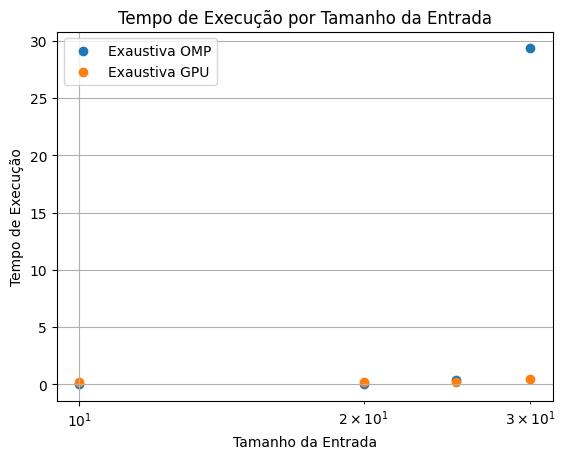

In [41]:
import json
from matplotlib import pyplot as plt

# Carregar os dados do arquivo JSON
with open("./data/output/exaustiva_omp/results.json", 'r') as file:
    exaustiva_omp = json.load(file)

with open("./data/output/exaustiva_gpu/results.json", 'r') as file:
    exaustiva_gpu = json.load(file)

# Separar os dados das duas heurísticas
heuristica1 = []
heuristica2 = []

for item in exaustiva_omp:
    if item['k'] == '4':
        heuristica1.append((int(item['n']), item['time']))
for item in exaustiva_gpu:
    if item['k'] == '4':
        heuristica2.append((int(item['n']), item['time']))

# Ordenar os dados por tamanho da entrada (X)
heuristica1 = sorted(heuristica1, key=lambda x: x[0])
heuristica2 = sorted(heuristica2, key=lambda x: x[0])

# Extrair os valores de X e Y para cada heurística
x1, y1 = zip(*heuristica1)
x2, y2 = zip(*heuristica2)

# Plotar o gráfico
plt.scatter(x1, y1,  label='Exaustiva OMP')
plt.scatter(x2, y2,  label='Exaustiva GPU')

plt.xlabel('Tamanho da Entrada')
plt.ylabel('Tempo de Execução')
plt.title('Tempo de Execução por Tamanho da Entrada')

plt.xscale('log')
plt.legend()
plt.grid(True)

plt.show()


No geral, percebe-se que o desempenho é próximo para valores pequenos. Porém, conforme se aumenta o tamanho da entrada, a GPU passa a ter um desempenho muito superior.

Como a estratégia utilizada cresce exponencialmente, o tempo de execução para valores maiores de N é muito alto. Por isso, não foi possível executar o algoritmo sequencial para valores maiores que 20.

Além disso, é necessário tomar o devido cuidado com a alocação em memória. Para valores muito grandes de N, a alocação de memória pode falhar, pois não há memória suficiente para alocar todos os vetores necessários.

# Comparando todas as heurísticas

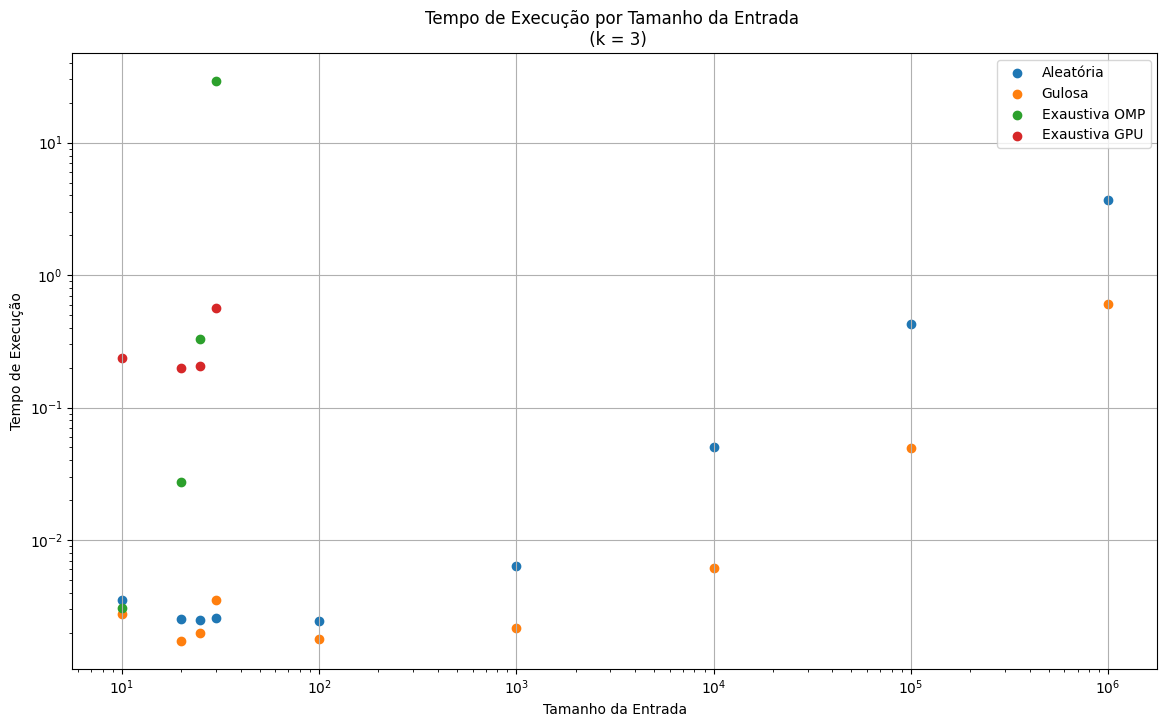

--- VALORES MÁXIMOS ---
# Gulosa
  -Tempo de Tela:  22
  -Filmes Assistidos:  8
# Aleatória
  -Tempo de Tela:  21
  -Filmes Assistidos:  8
# Exaustiva OMP
  -Tempo de Tela:  15
  -Filmes Assistidos:  7
# Exaustiva GPU
  -Tempo de Tela:  20
  -Filmes Assistidos:  6


In [47]:
import json
from matplotlib import pyplot as plt

# Carregar os dados do arquivo JSON
with open("./data/output/aleatorio/results.json", 'r') as file:
    data_aleatorio = json.load(file)

with open("./data/output/heuristica/results.json", 'r') as file:
    data_heuristica = json.load(file)

with open("./data/output/exaustiva_omp/results.json", 'r') as file:
    data_exaustiva_omp = json.load(file)

with open("./data/output/exaustiva_gpu/results.json", 'r') as file:
    data_exaustiva_gpu = json.load(file)

# Separar os dados das duas heurísticas
heuristica1 = []
heuristica2 = []
heuristica3 = []
heuristica4 = []

amount1 = []
amount2 = []
amount3 = []
amount4 = []
tempo_tela1 = []
tempo_tela2 = []
tempo_tela3 = []
tempo_tela4 = []


for item in data_aleatorio:
    if item['k'] == '3':
        heuristica1.append((int(item['n']), item['time']))
        amount1.append(item['n_selecionados'])
        tempo_tela1.append(item['tempo_tela'])
for item in data_heuristica:
    if item['k'] == '3':
        heuristica2.append((int(item['n']), item['time']))
        amount2.append(item['n_selecionados'])
        tempo_tela2.append(item['tempo_tela'])
for item in data_exaustiva_omp:
    if item['k'] == '3':
        heuristica3.append((int(item['n']), item['time']))
        amount3.append(item['n_selecionados'])
        tempo_tela3.append(item['tempo_tela'])
for item in data_exaustiva_gpu:
    if item['k'] == '3':
        heuristica4.append((int(item['n']), item['time']))
        amount4.append(item['n_selecionados'])
        tempo_tela4.append(item['tempo_tela'])

# Ordenar os dados por tamanho da entrada (X)
heuristica1 = sorted(heuristica1, key=lambda x: x[0])
heuristica2 = sorted(heuristica2, key=lambda x: x[0])
heuristica3 = sorted(heuristica3, key=lambda x: x[0])
heuristica4 = sorted(heuristica4, key=lambda x: x[0])

# Extrair os valores de X e Y para cada heurística
x1, y1 = zip(*heuristica1)
x2, y2 = zip(*heuristica2)
x3, y3 = zip(*heuristica3)
x4, y4 = zip(*heuristica4)

# Plotar o gráfico
plt.figure(figsize=(14,8))
plt.scatter(x1, y1,  label='Aleatória')
plt.scatter(x2, y2,  label='Gulosa')
plt.scatter(x3, y3,  label='Exaustiva OMP')
plt.scatter(x4, y4,  label='Exaustiva GPU')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Tamanho da Entrada')
plt.ylabel('Tempo de Execução')
plt.title('Tempo de Execução por Tamanho da Entrada \n (k = 3)')


plt.legend()
plt.grid(True)

plt.show()


print("--- VALORES MÁXIMOS ---")

print("# Gulosa")
print("  -Tempo de Tela: ", max(tempo_tela2))
print("  -Filmes Assistidos: ", max(amount2))
print("# Aleatória")
print("  -Tempo de Tela: ", max(tempo_tela1))
print("  -Filmes Assistidos: ", max(amount1))
print("# Exaustiva OMP")
print("  -Tempo de Tela: ", max(tempo_tela3))
print("  -Filmes Assistidos: ", max(amount3))
print("# Exaustiva GPU")
print("  -Tempo de Tela: ", max(tempo_tela4))
print("  -Filmes Assistidos: ", max(amount4))


Considerações:

- Para o algoritmo paralelo e via GPU, foi utilizado o algoritmo de força bruta, que testa todas as possibilidades. Por isso, não foi possível executar o algoritmo sequencial para valores maiores que 20. Seriam necessários tratativas mais específicas para tratar alocação de memória, por exemplo.

- Os algoritmos sequênciais foram expostos a uma variedade maior de valores de N e, por ventura, obtiveram resultado melhor que os algoritmos paralelos. Porém, em questões computacionais, o algoritmo da GPU obteve resultado muito melhor.

---
# Conclusão

Diante do exposto, fica evidente a dificuldade para resolver problemas como esse de alocação. Ao passo que podemos utilizar alguma heurística para obter soluções ótimas em tempo polinomial, a solução exata é inviável, quando os valores de entrada são muito grandes. Porém, com alguns recursos computacionais, como processamento em paralelo ou uso de GPU's, podemos tornar a solução um pouco mais ágil.

Utilizar esses recursos exige um pouco mais de conhecimento e cuidado, pois é necessário se atentar a detalhes como alocação de memória, transferência de dados entre CPU e GPU, etc. Além de não ser garantia de que obteremos resultados melhores, conforme pôde se observar com os códigos paralelizáveis, uma vez que há mais gastos computacionais necessários para se fazer distribuição de carga e para controlar o acesso concorrente a variáveis, por exemplo.

